In [ ]:
# Install required packages for the RAG system
%pip install -q langchain-ollama langchain langchain-community faiss-cpu langchain_huggingface rank_bm25 gradio nest_asyncio markdown2 ipywidgets langchain_openai

Note: you may need to restart the kernel to use updated packages.


## Chunks and Embedding loader 

In [1]:
import pickle
import os
from typing import List
from langchain.schema import Document


def load_chunks_from_disk(chunks_path: str) -> List[Document]:
    """
    Load document chunks from disk.
    
    Args:
        chunks_path: Path to the saved chunks file
        
    Returns:
        List of document chunks
    """
    print(f"\nLoading chunks from {chunks_path}...")
    
    # Check if file exists
    if not os.path.exists(chunks_path):
        raise FileNotFoundError(f"Chunks file not found at {chunks_path}")
    
    # Load the chunks from disk
    with open(chunks_path, "rb") as f:
        chunks = pickle.load(f)
    
    print(f"Loaded {len(chunks)} chunks from disk")
    return chunks

In [2]:
# Initialize embedding model and load vector store
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

# Load embedding model
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Load pre-existing vector store
loaded_faiss_store = FAISS.load_local(
    "/workspaces/RAG_BOT/LocalEmbeddings/Chatgpt_Enriched_Full_Embedding",
    embedding_model,
    allow_dangerous_deserialization=True
)
print("FAISS vector store loaded successfully.")

# Load the chunks also
chunks = load_chunks_from_disk("/workspaces/RAG_BOT/LocalChunks/document_chunks_20250719_091443.pkl")


FAISS vector store loaded successfully.

Loading chunks from /workspaces/RAG_BOT/LocalChunks/document_chunks_20250719_091443.pkl...
Loaded 683 chunks from disk


## LLM Configuration

In [3]:
# Initialize the LLM with rate limiting
from langchain_ollama import ChatOllama
from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_openai import ChatOpenAI
from getpass import getpass

# Configure rate limiting to prevent overloading the model
rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.1,
    check_every_n_seconds=0.1,
    max_bucket_size=10,
)

openai_api_key = getpass("Enter your OpenAI API key: ")

# Initialize the LLM
llm = ChatOpenAI(
    model_name="gpt-4o-mini",
    openai_api_key = openai_api_key,
    temperature=0.1,
    rate_limiter=rate_limiter
)

# RETRIEVAL METHODS

## Retrival Method-1  ensemble

In [38]:
# Set up retrievers
from langchain.retrievers import EnsembleRetriever
from langchain_community.retrievers import BM25Retriever

# Extract documents from the docstore
try:
    all_docs = [loaded_faiss_store.docstore._dict[doc_id] for doc_id in loaded_faiss_store.index_to_docstore_id.values()]
except AttributeError:
    # Fallback for different docstore structure
    all_docs = [loaded_faiss_store.docstore.get(doc_id) for doc_id in loaded_faiss_store.index_to_docstore_id.values()]

# Configure different retrieval methods
bm25_retriever = BM25Retriever.from_documents(all_docs)
bm25_retriever.k = 2

# Vector similarity retrieval with MMR
mmr_retriever = loaded_faiss_store.as_retriever(search_type="mmr", search_kwargs={"k": 2})

# Vector similarity with score threshold
sst_retriever = loaded_faiss_store.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={"score_threshold": 0.3, "k": 2}
)

# Create ensemble retriever combining multiple retrieval methods
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, mmr_retriever, sst_retriever],
    weights=[0.4, 0.3, 0.3]
)

In [39]:
# Set up prompt templates
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate

# Define system instructions for the model
SYSTEM_PROMPT = """
You are a highly knowledgeable and helpful CyberArk API documentation assistant. Your primary role is to answer developer questions accurately and clearly, *using only the provided API documentation context*.

**GENERAL RULES FOR ALL RESPONSES:**
1.  **Context Reliance:** Answer *ONLY* based on the provided "Documentation Context". Do not use external knowledge or invent information.
2.  **Handling Missing Information:** If the answer to the user's question is not explicitly found within the provided documentation context, politely state: "I don't have that specific information in the documentation I can access." Do NOT guess or invent details.
3.  **Markdown Formatting:** Always use Markdown for structuring your answers (headers, code blocks, bullet points, etc.) to enhance readability.


**SPECIFIC RESPONSE BEHAVIORS:**

* **IF the user input is a general greeting (e.g., "hello", "hi", "hey"):**
    * Respond politely as a friendly assistant.
    * Example: "Hello! I'm your CyberArk API assistant. How can I help you with the CyberArk API today?"

* **ELSE IF the user is asking about a specific API endpoint:**
    * Provide detailed endpoint information. This should include:
        * Path and HTTP method (GET, POST, PUT, DELETE)
        * Required parameters (query, path, body)
        * Security requirements
        * Request body schema (in JSON if available)
        * Response body schema (in JSON if available)
        * Any available sample requests and responses.
    * Format your response with markdown, using headers for sections and code blocks for JSON examples.

* **ELSE IF the user is asking a general question about CyberArk API functionality (not tied to a single endpoint):**
    * Answer based ONLY on the provided context.
    * Try to be clear, concise, informative and straight to the point.
    * Include relevant code examples only if it is asked in query.

* **ELSE IF the Documentation Context is not available or question is outside the scope of CyberArk API documentation:**
    * Politely state: "I'm specialized in CyberArk API documentation. I don't have information about that topic in my knowledge base."
"""


system_message = SystemMessagePromptTemplate.from_template(SYSTEM_PROMPT)

# Define how user questions and context are formatted
human_message = HumanMessagePromptTemplate.from_template(
    """
You are answering questions about CyberArk's API. Use the documentation context

Documentation Context:
----------------------
{context}

New User Question:
----------------------
{question}
"""
)


In [40]:
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from typing import List, Tuple, Optional
import time

def get_answer(query: str):
    
    # Skip retrieval for simple greetings
    greeting_terms = ["hello", "hi", "hey", "greetings"]
    is_greeting = any(term in query.lower() for term in greeting_terms) and len(query.split()) < 4
    
    if is_greeting:
        # Direct response for greetings without using retrieval
        response = "Hello! I'm your CyberArk API assistant. How can I help you with the CyberArk API today?"
    else:
        # Create a retrieval chain that combines context and chat history
        retrieval_chain = RunnableParallel(
            {"context": ensemble_retriever, "question": RunnablePassthrough()}
        )
        
        # Execute retrieval
        retrieval_output = retrieval_chain.invoke(query)
        
        # Format the retrieved documents into a single context string
        context_docs = retrieval_output["context"]
        context_text = "\n\n".join([doc.page_content for doc in context_docs])
        
        # Create the complete prompt
        chat_prompt = ChatPromptTemplate.from_messages([
            system_message,
            HumanMessagePromptTemplate.from_template(
                """
                You are answering questions about CyberArk's API. Use the documentation context

                Documentation Context:
                ----------------------
                {context}

                New User Question:
                ----------------------
                {question}
                """
            )
        ])
        
        # Create and execute the generation chain
        generation_chain = chat_prompt | llm
        
        # Add rate limiting to prevent API overload
        time.sleep(0.5)  # Simple rate limiting
        
        # Generate response
        response = generation_chain.invoke({
            "context": context_text,
            "question": query
        })
        
        # Extract the content from the response
        if hasattr(response, 'content'):
            response = response.content
    
    return response

## Retrieval Method-2 Neighbourhood Expansion

In [34]:
def find_common_documents(docs1, docs2):
    """
    Find common documents between two document arrays based on doc_index and chunk_index in metadata.
    If nothing is common, return the top document from each array.
    
    Args:
        docs1: First array of documents
        docs2: Second array of documents
        
    Returns:
        List of common documents or top documents if nothing in common
    """
    # Handle empty array scenarios
    if not docs1 and not docs2:
        return []
    if not docs1:
        return [docs2[0]] if docs2 else []
    if not docs2:
        return [docs1[0]] if docs1 else []
    
    # Create a set of (doc_index, chunk_index) tuples from the first array for faster lookups
    doc_identifiers = {(doc.metadata.get('doc_index'), doc.metadata.get('chunk_index')) 
                      for doc in docs1 
                      if 'doc_index' in doc.metadata and 'chunk_index' in doc.metadata}
    
    # Find common documents based on doc_index and chunk_index
    common_docs = [doc for doc in docs2 
                  if 'doc_index' in doc.metadata and 'chunk_index' in doc.metadata and
                  (doc.metadata.get('doc_index'), doc.metadata.get('chunk_index')) in doc_identifiers]
    
    # If no common documents, take top document from each array
    if not common_docs:
        return [docs1[0], docs2[0]]
    
    return common_docs


In [35]:
from typing import List, Dict, Any

def get_adjacent_docs(chunks: List[Document], doc_index: int, chunk_index_in_doc: int, doc_name: str, n: int = 1, debug = False) -> Dict[str, Any]:
    """
    Get a specific chunk and its adjacent chunks within the same document.
    
    Args:
        chunks: List of all document chunks
        doc_index: Index of the document
        chunk_index_in_doc: Index of the chunk within the document
        n: Number of adjacent chunks to retrieve in each direction (default: 1)
    
    Returns:
        Dictionary containing the current chunk and lists of previous and next chunks
    """
    # Find all chunks from the specified document
    doc_chunks = [
        chunk for chunk in chunks 
        if chunk.metadata.get("doc_index") == doc_index and
        chunk.metadata.get("doc_name") == doc_name
    ]
    
    if not doc_chunks:
        raise ValueError(f"No chunks found for document index {doc_index}")
    
    # Sort chunks by their position in the document
    doc_chunks.sort(key=lambda x: x.metadata.get("chunk_index"))
    
    # Find the specified chunk within the document chunks
    target_chunk = None
    current_position = -1
    
    for i, chunk in enumerate(doc_chunks):
        if chunk.metadata.get("chunk_index") == chunk_index_in_doc:
            target_chunk = chunk
            current_position = i
            break
    
    if current_position == -1:
        raise ValueError(f"Chunk with index {chunk_index_in_doc} not found in document {doc_index}")
    
    if debug:
        print(f"\nRetrieving adjacent chunks for document {doc_index}:")
        print(f"  Document name: {target_chunk.metadata.get('doc_name', 'Unknown')}")
        print(f"  Chunk position within document: {chunk_index_in_doc + 1} of {target_chunk.metadata.get('total_chunks_in_doc', 'Unknown')}")
        print(f"  Retrieving {n} chunks before and after")
    
    # Get previous n chunks (if available)
    prev_chunks = []
    start_idx = max(0, current_position - n)
    if start_idx < current_position:
        prev_chunks = doc_chunks[start_idx:current_position]
    
    # Get next n chunks (if available)
    next_chunks = []
    end_idx = min(len(doc_chunks), current_position + n + 1)
    if current_position + 1 < end_idx:
        next_chunks = doc_chunks[current_position + 1:end_idx]
    
    print(f"  Found {len(prev_chunks)} previous chunks and {len(next_chunks)} next chunks")
    
    return {
        "current_chunk": target_chunk,
        "prev_chunks": prev_chunks,
        "next_chunks": next_chunks,
        "all_doc_chunks": doc_chunks
    }

In [36]:

# Implement the neighborhood expansion retrieval method
def retrieve_docs_with_neighborhood_expansion(query):
    """
    Retrieve documents using both similarity and BM25 methods, then find common documents.
    This implements a form of 'neighborhood expansion' by combining multiple retrieval methods.
    
    Args:
        query: User query string
        
    Returns:
        List of relevant documents
    """

    # RETRIEVERS USED WITH THE FLOW
    similarity_docs = sst_retriever.invoke(query)
    bm25_docs = bm25_retriever.invoke(query)
    
    # Find common or top documents
    relevant_docs = find_common_documents(similarity_docs, bm25_docs)

    final_expanded_docs = []
    # Get the neighbourhood expansion
    if len(relevant_docs)>0:
        for doc in relevant_docs:
            chunk_index = doc.metadata.get('chunk_index')
            doc_index = doc.metadata.get('doc_index')
            doc_name = doc.metadata.get('doc_name')
            response = get_adjacent_docs(chunks, doc_index, chunk_index,doc_name, n=2)
            expanded_docs = response["prev_chunks"] + [response["current_chunk"]] + response["next_chunks"]
            final_expanded_docs.extend(expanded_docs) 
    return final_expanded_docs

In [37]:
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from typing import List, Tuple, Optional
import time
from IPython.display import display, Markdown, Latex


def get_answer_using_neighbourhood(query: str, debug=False):
    """
    Retrieve documents and generate a response with neighborhood expansion.
    
    Args:
        query: User question
        debug: Whether to print the final prompt for debugging (default: True)
        
    Returns:
        Response from the LLM
    """
    # Skip retrieval for simple greetings
    greeting_terms = ["hello", "hi", "hey", "greetings"]
    is_greeting = any(term in query.lower() for term in greeting_terms) and len(query.split()) < 4
    
    if is_greeting:
        # Direct response for greetings without using retrieval
        response = "Hello! I'm your CyberArk API assistant. How can I help you with the CyberArk API today?"
    else:
        # Format the retrieved documents into a single context string
        context_docs = retrieve_docs_with_neighborhood_expansion(query)
        context_text = "\n\n".join([doc.page_content for doc in context_docs])

        print(f"\nRetrieved {len(context_docs)} relevant documents for the query: '{query}'")
        
        # Create the complete prompt
        chat_prompt = ChatPromptTemplate.from_messages([
            system_message,
            HumanMessagePromptTemplate.from_template(
            """
            You are answering questions about CyberArk's API. Use the documentation context

            Documentation Context:
            ----------------------
            {context}

            New User Question:
            ----------------------
            {question}
            """
            )
        ])
        
        ######################## ONLY FOR DEBUGGING #######################################
        # Format the prompt with actual values to print it
        if debug:
            # Get the messages with variables filled in
            formatted_messages = chat_prompt.format_messages(
                context=context_text,
                question=query
            )
            
            # Print the complete formatted prompt 
            print("\n===== FINAL PROMPT SENT TO LLM =====")
            for i, message in enumerate(formatted_messages):
                role = message.type
                content = message.content
                print(f"\n--- Message {i+1} ({role}) ---")
                print(content)
            print("\n====================================")
        
        # Create and execute the generation chain
        generation_chain = chat_prompt | llm
        
        # Add rate limiting to prevent API overload
        time.sleep(0.5)  # Simple rate limiting
        
        # Generate response
        response = generation_chain.invoke({
            "context": context_text,
            "question": query
        })
        
        # Extract the content from the response
        if hasattr(response, 'content'):
            response = response.content
    
    return response


## Retrieval Method-3 Multiple Query Generation + BERT-Reranking Retriever

In [29]:
def get_descriptions_with_keyword_matching(query):
    """
    Retrieve keyword matching documents using BM25 and find their one-liner descriptions.
    
    Args:
        query: User query string
        
    Returns:
        Formatted string with category headers and one-liner descriptions
    """
    # 1. Retrieve documents using BM25 retriever
    retrieved_docs = bm25_retriever.invoke(query)
    
    # 2. Get top 2 documents
    top_docs = retrieved_docs[:2] if len(retrieved_docs) >= 2 else retrieved_docs
    
    # 3. Load OneLiners.json
    import json
    with open("/workspaces/RAG_BOT/Truths/OneLiners.json", "r") as f:
        one_liners_by_category = json.load(f)
    
    # 4. Process each document and find matching one-liners
    categories_found = []
    for doc in top_docs:
        # Extract category from doc_name
        category = "Unknown"
        
        if 'doc_name' in doc.metadata:
            doc_name = doc.metadata['doc_name']
            # Split by underscore and take the first part as category
            parts = doc_name.split('_')
            if parts:
                category = parts[0]        
        
        categories_found.append(category)

    categories_found = list(set(categories_found))  # Remove duplicates

    # Build formatted results with category headers
    formatted_results = []
    for category in categories_found:
        # Add the category as a header
        formatted_results.append(f"## {category}")
        # Add each description on a new line
        formatted_results.extend(one_liners_by_category[category])
    
    return formatted_results

# Example usage
# results = get_descriptions_with_keyword_matching("How to delete a policy?")
# print("\n".join(results))

In [30]:
from langchain_core.prompts import PromptTemplate


def generate_subqueries(query: str):
    """
    Generate 2-3 subqueries from a user query using LLM to help with retrieval.
    
    Args:
        query: User query string
        
    Returns:
        List of subqueries (2-3 refined queries)
    """
    # Get API context from keyword matching
    api_context = get_descriptions_with_keyword_matching(query)
    api_context_text = "\n".join(api_context)
    
    # Create the prompt for the LLM
    subquery_prompt = PromptTemplate.from_template("""
    You are a helpful assistant working with CyberArk API documentation. Given a user's natural language query, your task is to break it down into smaller, API-relevant subqueries. These subqueries should help clarify what exact information or API functionality the user is asking about, based on the available API endpoints.

    ## This is a detailed breakdown of all the available endpoints use this a context:
    {api_context_text}

    ## Guidelines:
    - Return 2 to 3 **clear and atomic** subqueries.
    - Each subquery should help narrow down or clarify user intent.
    - Focus strictly on what's possible based on the API spec.
    - Include any possible synonyms or related terms.
    - Include common ways developers might phrase this question.
    - Optionally incorporate relevant concepts such as endpoint names, paths, HTTP methods, parameters, request or response schemas if they are likely relevant.

    ### User Query:
    {query}

    ### Output format:
    - You should output 2-3 subqueries with comma seperation.
    - Example Output Format: sub_query1, subquery2, subquery3                                        
    """)
    
      # Generate evaluation response
    generation_chain = subquery_prompt | llm
    subquery_response = generation_chain.invoke({
        "api_context_text": api_context_text,
        "query" : query
    })

    # Extract content if using ChatOpenAI
    if hasattr(subquery_response, 'content'):
        subquery_response = subquery_response.content
    
    
    # First, try splitting by comma
    subqueries = [sq.strip() for sq in subquery_response.split(',')]

    subqueries.append(query) # Ensure original query is included
    
    return subqueries

# k = generate_subqueries("how to delete a policy?")
# print(k)

In [31]:
def retrieve_documents_with_query_expansion(query: str, debug: bool = False):
    """
    Retrieve documents using query expansion and multiple retrievers.
    
    This method:
    1. Generates multiple subqueries from the user's query
    2. Retrieves documents for each subquery using BM25 and similarity search
    3. Combines all results and removes duplicates based on document metadata
    
    Args:
        query: The user's original query
        debug: Whether to print detailed debug information
        
    Returns:
        List of unique relevant documents
    """
    if debug:
        print(f"Processing query: '{query}'")
    
    # Generate subqueries
    subqueries = generate_subqueries(query)
    
    if debug:
        print(f"Generated {len(subqueries)} subqueries:")
        for i, subq in enumerate(subqueries):
            print(f"  {i+1}. {subq}")
    
    # Initialize empty list to collect all documents
    all_docs = []
    
    # Process each subquery
    for i, subquery in enumerate(subqueries):
        if debug:
            print(f"Processing subquery {i+1}/{len(subqueries)}: '{subquery}'")
        
        # Get documents from BM25 retriever
        bm25_docs = bm25_retriever.invoke(subquery)
        if debug:
            print(f"BM25 retriever found {len(bm25_docs)} documents")
        
        # Get documents from similarity search retriever
        sst_docs = sst_retriever.invoke(subquery)
        if debug:
            print(f"Similarity retriever found {len(sst_docs)} documents")
        
        # Add all retrieved documents to our collection
        all_docs.extend(bm25_docs)
        all_docs.extend(sst_docs)
    
    if debug:
        print(f"Total documents retrieved: {len(all_docs)} (before deduplication)")
    
    # Remove duplicates based on doc_index and chunk_index
    unique_docs = []
    seen_indices = set()
    
    for doc in all_docs:
        # Extract document and chunk indices
        doc_index = doc.metadata.get('doc_index')
        chunk_index = doc.metadata.get('chunk_index')
        
        # Skip documents without proper metadata
        if doc_index is None or chunk_index is None:
            if debug:
                print(f"Skipping document with missing metadata: {doc.metadata}")
            continue
        
        # Create a unique identifier for this document chunk
        doc_identifier = (doc_index, chunk_index)
        
        # Add to unique docs if we haven't seen it before
        if doc_identifier not in seen_indices:
            seen_indices.add(doc_identifier)
            unique_docs.append(doc)
    
    if debug:
        print(f"After deduplication: {len(unique_docs)} unique documents")
        if len(unique_docs) > 0:
            # Show some information about the first few documents
            print("Sample of retrieved documents:")
            for i, doc in enumerate(unique_docs):
                doc_name = doc.metadata.get('doc_name', 'Unknown')
                print(f"  Document {i+1}: {doc_name} (doc_index={doc.metadata.get('doc_index')}, chunk_index={doc.metadata.get('chunk_index')})")
                content_preview = doc.page_content[:100] + "..." if len(doc.page_content) > 100 else doc.page_content
                print(f"  Preview: {content_preview}\n")
    
    return unique_docs

# # Example usage
# docs = retrieve_with_query_expansion("How to delete a policy?", debug=True)
# docs

In [32]:
from sentence_transformers import SentenceTransformer
import numpy as np
def get_bert_reordered_documents(query: str, debug: bool = False):
    """
    Retrieve and reorder documents using BERT embeddings to prioritize 
    by semantic similarity to the query. Only includes documents with
    similarity score > 0.2.
    
    Args:
        query: The user's query
        debug: Whether to print debug information
        
    Returns:
        List of documents reordered by relevance to the query with scores > 0.2
    """
    if debug:
        print(f"Processing query: '{query}'")
    
    # Get documents using query expansion
    retrieved_docs = retrieve_documents_with_query_expansion(query, debug=debug)
    
    if debug:
        print(f"Retrieved {len(retrieved_docs)} documents")
    
    if not retrieved_docs:
        return []
        
    # Initialize BERT model
    if debug:
        print("Loading BERT model for semantic reordering")
    model = SentenceTransformer('all-MiniLM-L6-v2')  # Using the same model as your embeddings
    
    # Extract document contents
    doc_texts = [doc.page_content for doc in retrieved_docs]
    
    # Compute embeddings
    if debug:
        print("Computing BERT embeddings for query and documents")
    query_embedding = model.encode([query])[0]
    doc_embeddings = model.encode(doc_texts)
    
    # Compute similarities
    similarities = []
    for i, doc_embedding in enumerate(doc_embeddings):
        similarity = np.dot(query_embedding, doc_embedding) / (
            np.linalg.norm(query_embedding) * np.linalg.norm(doc_embedding)
        )
        similarities.append((i, similarity))
    
    # Filter documents with similarity score above threshold (0.2)
    threshold = 0.2
    filtered_similarities = [(idx, score) for idx, score in similarities if score > threshold]
    
    if debug:
        print(f"Filtering documents with similarity score > {threshold}")
        print(f"Before filtering: {len(similarities)} documents")
        print(f"After filtering: {len(filtered_similarities)} documents")
    
    # Sort documents by similarity (highest first)
    filtered_similarities.sort(key=lambda x: x[1], reverse=True)
    
    # Reorder documents
    reordered_docs = [retrieved_docs[idx] for idx, _ in filtered_similarities]
    
    if debug:
        print("Documents reordered by semantic similarity to query")
        for i, (idx, score) in enumerate(filtered_similarities):
            doc = retrieved_docs[idx]
            print(f"  {i+1}. [{score:.4f}] {doc.metadata.get('doc_name', 'Unknown')}")
        
        if len(filtered_similarities) == 0:
            print("  No documents met the similarity threshold. Consider lowering the threshold.")
    
    return reordered_docs

# get_bert_reordered_documents("How to delete a policy?", debug=True)

In [33]:
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from typing import List, Tuple, Optional
import time
from IPython.display import display, Markdown, Latex


def get_answer_using_bert_based_reordering(query: str, debug=False):
    """
    Retrieve documents and generate a response with neighborhood expansion.
    
    Args:
        query: User question
        debug: Whether to print the final prompt for debugging (default: True)
        
    Returns:
        Response from the LLM
    """
    # Skip retrieval for simple greetings
    greeting_terms = ["hello", "hi", "hey", "greetings"]
    is_greeting = any(term in query.lower() for term in greeting_terms) and len(query.split()) < 4
    
    if is_greeting:
        # Direct response for greetings without using retrieval
        response = "Hello! I'm your CyberArk API assistant. How can I help you with the CyberArk API today?"
    else:
        # Format the retrieved documents into a single context string
        context_docs = get_bert_reordered_documents(query, debug)
        context_text = "\n\n".join([doc.page_content for doc in context_docs])

        print(f"\nRetrieved {len(context_docs)} relevant documents for the query: '{query}'")
        
        # Create the complete prompt
        chat_prompt = ChatPromptTemplate.from_messages([
            system_message,
            HumanMessagePromptTemplate.from_template(
            """
            You are answering questions about CyberArk's API. Use the documentation context

            Documentation Context:
            ----------------------
            {context}

            New User Question:
            ----------------------
            {question}
            """
            )
        ])
        
        ######################## ONLY FOR DEBUGGING #######################################
        # Format the prompt with actual values to print it
        if debug:
            # Get the messages with variables filled in
            formatted_messages = chat_prompt.format_messages(
                context=context_text,
                question=query
            )
            
            # Print the complete formatted prompt 
            print("\n===== FINAL PROMPT SENT TO LLM =====")
            for i, message in enumerate(formatted_messages):
                role = message.type
                content = message.content
                print(f"\n--- Message {i+1} ({role}) ---")
                print(content)
            print("\n====================================")
        
        # Create and execute the generation chain
        generation_chain = chat_prompt | llm
        
        # Add rate limiting to prevent API overload
        time.sleep(0.5)  # Simple rate limiting
        
        # Generate response
        response = generation_chain.invoke({
            "context": context_text,
            "question": query
        })
        
        # Extract the content from the response
        if hasattr(response, 'content'):
            response = response.content
    
    return response

# display(Markdown(get_answer_using_bert_based_reordering("How to delete a policy?", debug=True)))

## Retrieval Method - 4  - Recursive Retrieval-Generation with Self-Correction

In [26]:
from langchain_core.prompts import PromptTemplate
import re


def identify_knowledge_gaps(query: str, initial_response: str):
    """
    Have the LLM identify knowledge gaps in its initial response.
    
    Args:
        query: The original user query
        initial_response: The first-pass response from the LLM
        
    Returns:
        List of follow-up queries to fill identified gaps
    """
    # Create the prompt for gap identification
    gap_prompt = PromptTemplate.from_template("""
    You are analyzing a response to a user question about the CyberArk API. Your goal is to identify any information gaps, 
    uncertainties, or areas where more specific details would improve the answer.
    
    Original Question: {query}
    
    Response to Analyze: {response}
    
    Think about:
    1. Missing technical details that would make the answer more complete
    2. Ambiguous statements that need clarification
    3. API parameters, options, or behaviors not fully explained
    4. Missing examples or use cases that would improve understanding
    5. Areas where the answer expresses uncertainty or lack of information
    
    For each gap you identify, formulate a specific follow-up query that would help retrieve the missing information.
    Return a list of 1-3 follow-up queries, formatted as a comma-separated list.
    
    If the response seems comprehensive and doesn't have significant gaps, return "COMPLETE".
    
    Follow-up Queries:
    """)
    
    # Generate the gap analysis
    generation_chain = gap_prompt | llm
    gap_response = generation_chain.invoke({
        "query": query,
        "response": initial_response
    })
    
    # Extract content if using ChatOpenAI
    if hasattr(gap_response, 'content'):
        gap_response = gap_response.content
    
    # If the LLM thinks the response is complete, return empty list
    if "COMPLETE" in gap_response:
        return []
    
    # Split the follow-up queries
    follow_up_queries = [q.strip() for q in gap_response.split(',')]
    return follow_up_queries

In [27]:

def get_answer_with_recursive_generation(query: str, debug=False):
    """
    Implement the recursive retrieval-generation technique.
    
    Args:
        query: User question
        debug: Whether to print debug information
        
    Returns:
        Enhanced response from the LLM
    """
    # Skip retrieval for simple greetings
    greeting_terms = ["hello", "hi", "hey", "greetings"]
    is_greeting = any(term in query.lower() for term in greeting_terms) and len(query.split()) < 4
    
    if is_greeting:
        return "Hello! I'm your CyberArk API assistant. How can I help you with the CyberArk API today?"
    
    # STEP 1: Initial retrieval using an existing method (choose the best one as base)
    # Let's use BERT reranking as our base method
    if debug:
        print(f"STEP 1: Initial retrieval for query: '{query}'")
    
    initial_docs = get_bert_reordered_documents(query, debug=debug)
    initial_context = "\n\n".join([doc.page_content for doc in initial_docs])
    
    if debug:
        print(f"Retrieved {len(initial_docs)} documents for initial context")
    
    # STEP 2: Generate initial response
    if debug:
        print("STEP 2: Generating initial response")
    
    chat_prompt = ChatPromptTemplate.from_messages([
        system_message,
        HumanMessagePromptTemplate.from_template(
        """
        You are answering questions about CyberArk's API. Use the documentation context

        Documentation Context:
        ----------------------
        {context}

        New User Question:
        ----------------------
        {question}
        """
        )
    ])
    
    generation_chain = chat_prompt | llm
    initial_response = generation_chain.invoke({
        "context": initial_context,
        "question": query
    })
    
    if hasattr(initial_response, 'content'):
        initial_response = initial_response.content
    
    # STEP 3: Identify knowledge gaps
    if debug:
        print("STEP 3: Analyzing initial response for knowledge gaps")
    
    follow_up_queries = identify_knowledge_gaps(query, initial_response)
    
    if not follow_up_queries:
        if debug:
            print("No knowledge gaps identified. Returning initial response.")
        return initial_response
    
    if debug:
        print(f"Identified {len(follow_up_queries)} knowledge gaps:")
        for i, fq in enumerate(follow_up_queries):
            print(f"  {i+1}. {fq}")
    
    # STEP 4: Retrieve additional context for follow-up queries
    if debug:
        print("STEP 4: Retrieving additional context for follow-up queries")
    
    additional_docs = []
    for follow_up in follow_up_queries:
        # Use a different retrieval method for diversity
        follow_up_docs = retrieve_docs_with_neighborhood_expansion(follow_up)
        additional_docs.extend(follow_up_docs)
    
    # Remove duplicates
    seen_indices = set()
    unique_additional_docs = []
    
    for doc in additional_docs:
        doc_index = doc.metadata.get('doc_index')
        chunk_index = doc.metadata.get('chunk_index')
        
        if doc_index is None or chunk_index is None:
            continue
        
        doc_identifier = (doc_index, chunk_index)
        
        if doc_identifier not in seen_indices:
            seen_indices.add(doc_identifier)
            unique_additional_docs.append(doc)
    
    if debug:
        print(f"Retrieved {len(unique_additional_docs)} additional documents")
    
    # STEP 5: Generate enhanced response with combined context
    if debug:
        print("STEP 5: Generating enhanced response with combined context")
    
    # Combine initial and additional context
    additional_context = "\n\n".join([doc.page_content for doc in unique_additional_docs])
    combined_context = f"{initial_context}\n\n{additional_context}"
    
    # Create prompt for final generation
    enhanced_prompt = ChatPromptTemplate.from_messages([
        system_message,
        HumanMessagePromptTemplate.from_template(
        """
        You are answering questions about CyberArk's API. Use the documentation context below.
        
        This context includes both initial information and additional details to provide a more complete answer.

        Documentation Context:
        ----------------------
        {context}

        User Question:
        ----------------------
        {question}
        
        Your previous response had some gaps or uncertainties. With the additional context, provide an enhanced, 
        more complete response that addresses those gaps while maintaining accuracy and clarity.
        """
        )
    ])
    
    # Generate enhanced response
    enhanced_generation_chain = enhanced_prompt | llm
    enhanced_response = enhanced_generation_chain.invoke({
        "context": combined_context,
        "question": query
    })
    
    if hasattr(enhanced_response, 'content'):
        enhanced_response = enhanced_response.content
    
    if debug:
        print("Recursive retrieval-generation complete")
    
    return enhanced_response

In [28]:
# get_answer_with_recursive_generation("How to delete a policy?", debug=True)

## Retrieval Method - 5  : Dynamic Prompt Engineering Retrieval Method

In [23]:
import json
from langchain_core.prompts import PromptTemplate
def analyze_query_and_generate_prompts(query: str, debug: bool = False):
    """
    Use the LLM to analyze the query and generate tailored system and user prompts.
    
    Args:
        query: The user's question
        debug: Whether to print debug information
        
    Returns:
        Dictionary containing tailored system prompt and user message template
    """
    # Create the prompt analyzer template
    prompt_analyzer_template = PromptTemplate.from_template("""
    You are an expert in prompt engineering for large language models. Your task is to analyze a user query about the CyberArk API 
    and create the optimal system prompt and user message template to get the best possible response.
    
    ### User Query:
    {query}
    
    ### Analysis Instructions:
    1. Identify the query type (API endpoint details, general concept, troubleshooting, etc.)
    2. Determine what specific API documentation information would be most relevant
    3. Consider what specific formatting or structure would best present this information
    
    ### Output Format:
    Return a JSON object with two fields:
    1. "system_prompt": A tailored system prompt that gives the model specific instructions about how to handle this type of query
    2. "user_message_template": A template for structuring the user message with the context and query
    
    The system_prompt should provide specific instructions about:
    - How to structure the response for this query type
    - What details to prioritize and emphasize
    - Any specific formatting considerations (code blocks, tables, etc.)
    - How to handle potential ambiguities or limitations

    The user_message_template should include placeholders for {{context}} and {{question}}.

    Example output format:
    ```json
    {{
      "system_prompt": "You are a CyberArk API documentation expert...[detailed tailored instructions]...",
      "user_message_template": "Here is documentation about the CyberArk API:\\n\\nContext:\\n{{context}}\\n\\nUser Question:\\n{{question}}\\n\\nProvide a comprehensive answer focusing on..."
    }}
    ```
    """)
    
    # Generate the prompts
    generation_chain = prompt_analyzer_template | llm
    analyzer_response = generation_chain.invoke({"query": query})
    
    # Extract content if using ChatOpenAI
    if hasattr(analyzer_response, 'content'):
        analyzer_response = analyzer_response.content
    
    # Parse the JSON response
    try:
        # Remove markdown code block markers if present
        analyzer_response = analyzer_response.replace("```json", "").replace("```", "").strip()
        prompt_components = json.loads(analyzer_response)
        
        if debug:
            print("\n=== DYNAMICALLY GENERATED PROMPTS ===")
            print(f"\nSYSTEM PROMPT:\n{prompt_components['system_prompt']}")
            print(f"\nUSER MESSAGE TEMPLATE:\n{prompt_components['user_message_template']}")
            print("\n======================================")
        
        return prompt_components
    except json.JSONDecodeError as ex:
        print(f"Error parsing prompt components: {ex}")
        print(f"Raw response: {analyzer_response}")
        raise ex

In [24]:

def get_answer_with_dynamic_prompting(query: str, debug: bool = False):
    """
    Generate answers using dynamically generated prompts tailored to the query.
    
    Args:
        query: The user's question
        debug: Whether to print debug information
        
    Returns:
        Response from the LLM
    """
    # Skip retrieval for simple greetings
    greeting_terms = ["hello", "hi", "hey", "greetings"]
    is_greeting = any(term in query.lower() for term in greeting_terms) and len(query.split()) < 4
    
    if is_greeting:
        return "Hello! I'm your CyberArk API assistant. How can I help you with the CyberArk API today?"
    
    # Step 1: Retrieve relevant documents using the best retrieval method
    # Using BERT reranking as it's shown good performance
    if debug:
        print(f"Retrieving documents for query: '{query}'")
    
    context_docs = get_bert_reordered_documents(query, debug=debug)
    context_text = "\n\n".join([doc.page_content for doc in context_docs])
    
    if debug:
        print(f"Retrieved {len(context_docs)} relevant documents")
    
    # Step 2: Generate dynamic prompts tailored to this specific query
    prompt_components = analyze_query_and_generate_prompts(query, debug=debug)
    
    # Step 3: Create chat prompt with the dynamically generated components
    system_message_prompt = SystemMessagePromptTemplate.from_template(
        prompt_components["system_prompt"]
    )
    
    human_message_prompt = HumanMessagePromptTemplate.from_template(
        prompt_components["user_message_template"]
    )
    
    chat_prompt = ChatPromptTemplate.from_messages([
        system_message_prompt,
        human_message_prompt
    ])
    
    # Step 4: Generate response with the customized prompt
    generation_chain = chat_prompt | llm
    
    # Add rate limiting
    time.sleep(0.5)
    
    response = generation_chain.invoke({
        "context": context_text,
        "question": query
    })
    
    # Extract the content from the response
    if hasattr(response, 'content'):
        response = response.content
    
    return response

In [25]:
# get_answer_with_dynamic_prompting("How to delete a policy?", debug=True)  # Example usage
# display(Markdown(get_answer_with_dynamic_prompting("How to delete a policy?", debug=True)))

# LLM JUDGE

## Code Automation

### Load the questions

In [44]:
import json


with open("/workspaces/RAG_BOT/Truths/FullQuestions_GPT.json") as f:
    questions = json.load(f)

print(f"Loaded {len(questions)} evaluation questions.")

Loaded 30 evaluation questions.


### Create a Methods for LLM as Judge

In [42]:
import json
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from langchain_core.prompts import PromptTemplate

def evaluate_with_llm_judge(question, reference_answer, generated_answer):
    """
    Use the LLM to evaluate a generated answer against a reference answer.
    
    Args:
        question: The original question
        reference_answer: The ground truth answer
        generated_answer: The answer generated by the retrieval method
        
    Returns:
        JSON response with scores and feedback
    """
    # Create the prompt for the LLM judge
    judge_prompt = PromptTemplate.from_template("""
        You are an impartial judge evaluating the quality of answers provided by a chatbot based on a given reference answer. Your goal is to provide a comprehensive and fair assessment, focusing on accuracy, completeness, conciseness, clarity, adherence to instructions, and overall relevance.

            You will be given:

            1. **Question:** {QUESTION}
            2. **Reference Answer:** {REFERENCE_ANSWER}
            3. **Generated Answer:** {GENERATED_ANSWER}

            Your task is to compare the generated answer against the reference answer and assign scores based on the following criteria. Each score should be an integer from 1 to 5, where 1 is "Poor" and 5 is "Excellent".

            ---

            **Evaluation Criteria:**

            * **Accuracy (Score 1-5):**
                * How factually correct is the generated answer compared to the reference answer?
                * Does it contain any incorrect information or hallucinations?
                * Does it correctly interpret the intent of the question?
                * Score 1: Contains significant factual errors or hallucinations.
                * Score 2: Contains minor factual errors or some misinterpretations.
                * Score 3: Mostly accurate, but may have slight inaccuracies or omissions.
                * Score 4: Highly accurate, with no factual errors.
                * Score 5: Perfectly accurate and precise.

            * **Completeness (Score 1-5):**
                * Does the generated answer cover all the essential points and details present in the reference answer?
                * Does it omit any crucial information?
                * Score 1: Misses most essential information.
                * Score 2: Misses several key points.
                * Score 3: Covers most key points, but might omit some minor details.
                * Score 4: Covers almost all essential points comprehensively.
                * Score 5: Fully covers all essential points and details.

            * **Conciseness (Score 1-5):**
                * Is the generated answer to the point and free of unnecessary verbosity or repetition?
                * Does it provide relevant information without excessive preamble or redundant phrasing?
                * Score 1: Extremely verbose, repetitive, or contains irrelevant information.
                * Score 2: Noticeably verbose or somewhat repetitive.
                * Score 3: Generally concise, but could be slightly tighter.
                * Score 4: Concise and to the point.
                * Score 5: Perfectly concise and efficient.

            * **Clarity & Readability (Score 1-5):**
                * Is the generated answer easy to understand and well-structured?
                * Is the language clear, and is the formatting appropriate (e.g., use of bullet points, code blocks, bolding if applicable)?
                * Score 1: Difficult to understand, poorly structured, or confusing.
                * Score 2: Some parts are unclear or structure is lacking.
                * Score 3: Generally clear, but could be better organized or phrased.
                * Score 4: Clear, well-organized, and easy to read.
                * Score 5: Exceptionally clear, well-structured, and highly readable.

            * **Adherence to Instructions (Score 1-5):**
                * Does the generated answer follow any specific formatting rules or constraints (e.g., citation format, JSON structure if applicable for the chatbot's task, *not* inventing details, etc.)?
                * Does it correctly cite sources where required?
                * Score 1: Fails to follow most key instructions or violates major constraints.
                * Score 2: Fails to follow several instructions or has significant deviations.
                * Score 3: Follows most instructions, but has some minor deviations.
                * Score 4: Follows almost all instructions correctly.
                * Score 5: Perfectly adheres to all specified instructions.

            * **Relevance to Expected Answer (Score 1-5):**
                * How well does the generated answer match the *meaning*, *intent*, and *scope* of the reference answer?
                * Does it address the same core question in a way that is meaningfully equivalent?
                * Score 1: Entirely off-topic or unrelated to reference answer.
                * Score 2: Weak relevance, only partially addresses the expected content.
                * Score 3: Moderately relevant, but misses some key intent or scope.
                * Score 4: Strongly relevant, very close match to intent and scope.
                * Score 5: Perfectly relevant, fully equivalent in meaning and intent.

            ---

            **Output Format:**

            Your output must be a JSON object with the following structure:

            ```json
            {{
                "scores": {{
                    "accuracy": <score_1_5>,
                    "completeness": <score_1_5>,
                    "conciseness": <score_1_5>,
                    "clarity_readability": <score_1_5>,
                    "adherence_to_instructions": <score_1_5>,
                    "relevance_to_expected_answer": <score_1_5>
                }},
                "feedback": {{
                    "accuracy_notes": "<brief explanation for accuracy score, especially if not 5>",
                    "completeness_notes": "<brief explanation for completeness score, especially if not 5>",
                    "conciseness_notes": "<brief explanation for conciseness score, especially if not 5>",
                    "clarity_readability_notes": "<brief explanation for clarity & readability score, especially if not 5>",
                    "adherence_to_instructions_notes": "<brief explanation for adherence score, especially if not 5>",
                    "relevance_to_expected_answer_notes": "<brief explanation for relevance score, especially if not 5>",
                    "overall_summary": "<brief overall assessment of the generated answer, highlighting strengths and weaknesses>"
                }}
            }}
            ```
          
""")

    # Generate evaluation response
    generation_chain = judge_prompt | llm
    evaluation_response = generation_chain.invoke({
        "QUESTION": question,
        "REFERENCE_ANSWER": reference_answer,
        "GENERATED_ANSWER": generated_answer
    })
    
    # Extract content if using ChatOpenAI
    if hasattr(evaluation_response, 'content'):
        evaluation_response = evaluation_response.content

    # Parse the JSON response
    try:
        # Remove markdown code block markers if present
        evaluation_response = evaluation_response.replace("```json", "").replace("```", "").strip()
        evaluation_json = json.loads(evaluation_response)
        return evaluation_json
    except json.JSONDecodeError:
        print('----------- ERROR -------------')
        print(f"Error parsing JSON from LLM response. Raw response:\n{evaluation_response}")
        # Return a placeholder with error information
        return {
            "scores": {
                "accuracy": 0,
                "completeness": 0,
                "conciseness": 0,
                "clarity_readability": 0,
                "adherence_to_instructions": 0,
                "relevance_to_expected_answer": 0
            },
            "feedback": {
                "overall_summary": "Error parsing LLM response"
            },
            "raw_response": evaluation_response
        }



### Run Parallel Evaluations for multiple methods

In [ ]:
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm  # Import tqdm for Jupyter notebooks

def run_evaluation_parallel(questions, methods_dict, num_samples=None, max_workers=4):
    """
    Run evaluation on questions in parallel using multiple threads.
    
    Args:
        questions: List of question objects with category, question, answer, and difficulty
        methods_dict: Dictionary mapping method names to functions that take a question and return an answer
        num_samples: Optional number of questions to sample (for testing)
        max_workers: Maximum number of parallel workers (threads)
        
    Returns:
        DataFrame with all evaluation results
    """
    # Optionally sample a subset of questions
    if num_samples and num_samples < len(questions):
        import random
        sampled_questions = random.sample(questions, num_samples)
    else:
        sampled_questions = questions
    
    # Initialize a list to store all results (will be accessed by multiple threads)
    results = []
    
    # Create a lock to protect the results list during updates
    import threading
    results_lock = threading.Lock()
    
    # Function to process a single question (will be called in parallel)
    def process_question(question_data):
        i, q = question_data
        question_text = q["question"]
        reference_answer = q["answer"]
        category = q["category"]
        difficulty = q["difficulty"]
        
        question_results = []
        
        try:
            print(f"\nEvaluating question {i+1}/{len(sampled_questions)}")
            print(f"Category: {category}, Difficulty: {difficulty}")
            print(f"Question: {question_text}")
            
            # Get answers from all methods
            method_answers = {}
            
            # Generate answers from each method
            for method_name, method_func in methods_dict.items():
                print(f"\nGenerating answer with {method_name} for question {i+1}...")
                method_answers[method_name] = method_func(question_text)
            
            # Evaluate each method
            for method_name, answer in method_answers.items():
                print(f"\nEvaluating {method_name} answer for question {i+1}...")
                evaluation = evaluate_with_llm_judge(
                    question_text, reference_answer, answer
                )
                
                # Create a result dictionary
                result = {
                    "question_id": i,
                    "question": question_text,
                    "reference_answer": reference_answer,
                    "category": category,
                    "difficulty": difficulty,
                    "method": method_name,
                    "generated_answer": answer,
                    # Keep the original nested dictionaries for backward compatibility
                    "scores": evaluation.get("scores", {}),
                    "feedback": evaluation.get("feedback", {})
                }
                
                # Add individual score fields
                scores = evaluation.get("scores", {})
                for score_key in ["accuracy", "completeness", "conciseness", "clarity_readability", 
                                "adherence_to_instructions", "relevance_to_expected_answer"]:
                    result[f"score_{score_key}"] = scores.get(score_key, 0)
                
                # Add individual feedback fields
                feedback = evaluation.get("feedback", {})
                for feedback_key in ["accuracy_notes", "completeness_notes", "conciseness_notes", 
                                    "clarity_readability_notes", "adherence_to_instructions_notes", 
                                    "relevance_to_expected_answer_notes", "overall_summary"]:
                    result[f"feedback_{feedback_key}"] = feedback.get(feedback_key, "")
                
                question_results.append(result)
            
            # Save the results from this question
            with results_lock:
                results.extend(question_results)
                # Save intermediate results after each question
                interim_df = pd.DataFrame(results)
                interim_df.to_json("evaluation_results_interim.json", orient="records", indent=2)
                
            return True, i
            
        except Exception as e:
            print(f"Error processing question {i+1}: {e}")
            return False, i
    
    # Create a thread pool and process questions in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all questions to the executor
        future_to_question = {
            executor.submit(process_question, (i, q)): (i, q) 
            for i, q in enumerate(sampled_questions)
        }
        
        # Process results as they complete with a progress bar
        total = len(future_to_question)
        with tqdm(total=total, desc="Processing questions") as pbar:
            for future in concurrent.futures.as_completed(future_to_question):
                i, q = future_to_question[future]
                try:
                    success, question_id = future.result()
                    if success:
                        print(f"Question {question_id+1} completed successfully")
                    else:
                        print(f"Question {question_id+1} failed")
                except Exception as e:
                    print(f"Question {i+1} generated an exception: {e}")
                pbar.update(1)
    
    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(results)
    
    # Save the full results
    results_df.to_json("evaluation_results_final.json", orient="records", indent=2)
        
    return results_df

### Run the Evaluation

In [12]:
results_df = pd.read_json("/workspaces/RAG_BOT/evaluation_results_final.json")

In [13]:
results_df

,question_id,question,reference_answer,category,difficulty,method,generated_answer,scores,feedback,score_accuracy,...,score_clarity_readability,score_adherence_to_instructions,score_relevance_to_expected_answer,feedback_accuracy_notes,feedback_completeness_notes,feedback_conciseness_notes,feedback_clarity_readability_notes,feedback_adherence_to_instructions_notes,feedback_relevance_to_expected_answer_notes,feedback_overall_summary
0,0,Which specific endpoint is used to delete an a...,"To delete an application, you must use the `PO...",Basic endpoint recall,easy,Simple Ensemble Retriever,The specific endpoint used to delete an applic...,"{'accuracy': 4, 'completeness': 3, 'concisenes...",{'accuracy_notes': 'The generated answer accur...,4,...,4,4,4,The generated answer accurately identifies the...,While the answer includes the endpoint and met...,"The answer is generally concise, providing nec...","The structure is clear and easy to read, with ...","The answer follows the instructions well, but ...",The answer is relevant and closely matches the...,The generated answer is mostly accurate and re...
1,0,Which specific endpoint is used to delete an a...,"To delete an application, you must use the `PO...",Basic endpoint recall,easy,Neighbourhood Expansion,To delete an application that has been added b...,"{'accuracy': 5, 'completeness': 5, 'concisenes...",{'accuracy_notes': 'The generated answer accur...,5,...,5,5,5,The generated answer accurately reflects the e...,All essential details from the reference answe...,"The answer is mostly concise, but the inclusio...","The answer is well-structured, using bullet po...",The generated answer follows the instructions ...,"The answer is fully relevant, addressing the c...","The generated answer is comprehensive, accurat..."
2,0,Which specific endpoint is used to delete an a...,"To delete an application, you must use the `PO...",Basic endpoint recall,easy,BERT-Reranking Retriever,The specific endpoint used to delete an applic...,"{'accuracy': 5, 'completeness': 4, 'concisenes...",{'accuracy_notes': 'The generated answer accur...,5,...,5,5,5,The generated answer accurately identifies the...,The answer is mostly complete but omits the re...,The answer is concise and avoids unnecessary v...,The answer is well-structured and easy to read...,The answer follows the required format and doe...,The answer is highly relevant and directly add...,"Overall, the generated answer is strong, with ..."
3,0,Which specific endpoint is used to delete an a...,"To delete an application, you must use the `PO...",Basic endpoint recall,easy,Recursive Retrieval-Generation with Self-Corre...,To delete an application that has been added b...,"{'accuracy': 5, 'completeness': 5, 'concisenes...",{'accuracy_notes': 'The generated answer accur...,5,...,5,5,5,The generated answer accurately describes the ...,It includes all essential details from the ref...,"While mostly concise, the inclusion of detaile...","The answer is well-structured, using headings ...","The answer follows the instructions perfectly,...","The generated answer is fully relevant, addres...","The generated answer is comprehensive, accurat..."
4,0,Which specific endpoint is used to delete an a...,"To delete an application, you must use the `PO...",Basic endpoint recall,easy,Dynamic Prompt Engineering Retrieval Method,To delete an application that has been added b...,"{'accuracy': 4, 'completeness': 4, 'concisenes...",{'accuracy_notes': 'The generated answer is mo...,4,...,5,5,5,The generated answer is mostly accurate but in...,"The answer covers most essential points, inclu...","The answer is generally concise, though it cou...",The answer is exceptionally clear and well-str...,The generated answer follows the formatting an...,The answer is highly relevant and addresses th...,"Overall, the generated answer is strong, with ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,29,Explain how you would use a combin

# PLOTS

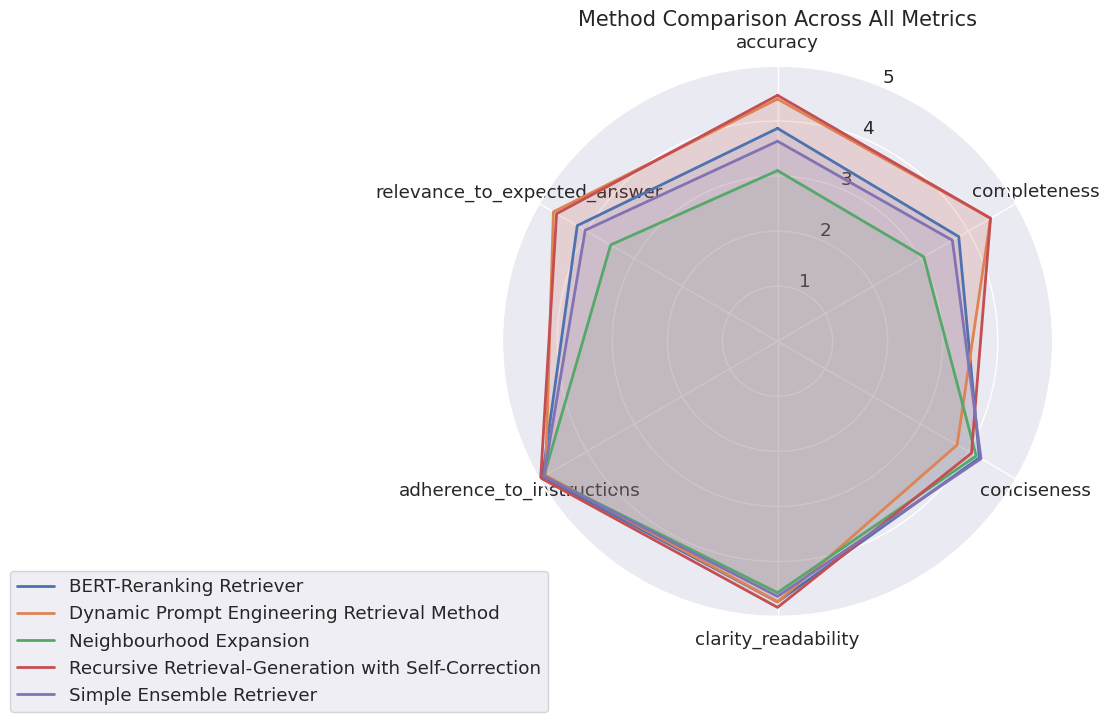

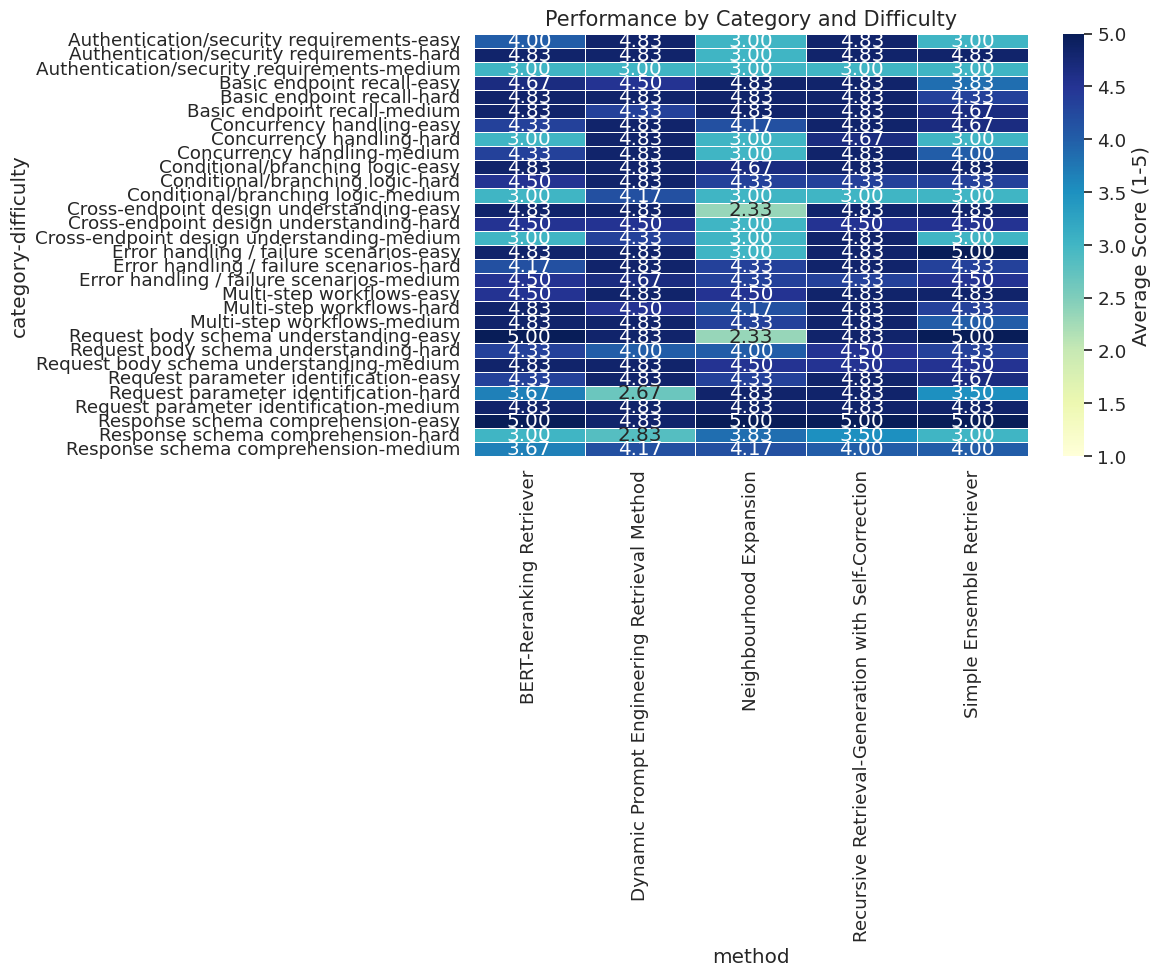

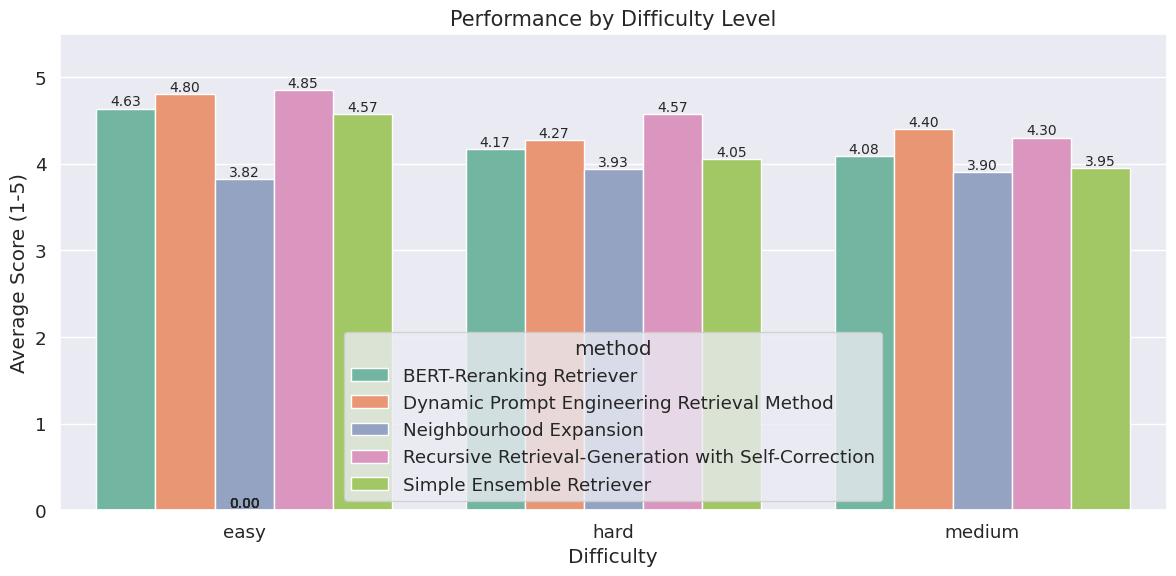

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the plotting style
plt.style.use('ggplot')
sns.set(font_scale=1.2)

# Create a radar chart to compare methods across all metrics
def plot_radar_chart(df):
    # Get the average scores for each method and metric
    metrics = ["score_accuracy", "score_completeness", "score_conciseness", 
               "score_clarity_readability", "score_adherence_to_instructions", 
               "score_relevance_to_expected_answer"]
    
    # Calculate mean scores by method
    avg_scores = df.groupby("method")[metrics].mean().reset_index()
    
    # Set up the radar chart
    methods = avg_scores["method"].tolist()
    metric_labels = [m.replace("score_", "") for m in metrics]
    
    # Number of metrics
    N = len(metrics)
    
    # Create angles for each metric
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))
    
    # Add each method as a separate line
    for i, method in enumerate(methods):
        values = avg_scores.loc[avg_scores["method"] == method, metrics].values.flatten().tolist()
        values += values[:1]  # Close the loop
        
        # Plot the line
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=method)
        ax.fill(angles, values, alpha=0.1)
    
    # Fix axis to go in the right order and start at 12 o'clock
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    # Draw axis lines for each metric and label
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_labels)
    
    # Draw y-axis labels (0-5)
    ax.set_ylim(0, 5)
    ax.set_yticks([1, 2, 3, 4, 5])
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.title('Method Comparison Across All Metrics', size=15)
    plt.tight_layout()
    plt.show()

# Call the function with your results DataFrame
plot_radar_chart(results_df)

# Create a heatmap to show performance by category and difficulty
def plot_performance_heatmap(df):
    # Calculate average overall scores (mean of all score metrics)
    score_cols = [col for col in df.columns if col.startswith('score_')]
    df['avg_score'] = df[score_cols].mean(axis=1)
    
    # Pivot to create heatmap data
    heatmap_data = df.pivot_table(
        index=['category', 'difficulty'],
        columns='method',
        values='avg_score',
        aggfunc='mean'
    )
    
    # Sort by category and difficulty
    heatmap_data = heatmap_data.sort_index(level=[0, 1])
    
    # Create the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        heatmap_data,
        annot=True,
        cmap='YlGnBu',
        linewidths=0.5,
        fmt='.2f',
        vmin=1,
        vmax=5,
        cbar_kws={'label': 'Average Score (1-5)'}
    )
    plt.title('Performance by Category and Difficulty', size=15)
    plt.tight_layout()
    plt.show()
    
    return heatmap_data

# Generate the heatmap
performance_by_category = plot_performance_heatmap(results_df)

# Create bar charts to compare methods by difficulty
def plot_difficulty_comparison(df):
    # Get average scores by method and difficulty
    difficulty_scores = df.groupby(['method', 'difficulty'])[
        [col for col in df.columns if col.startswith('score_')]
    ].mean().reset_index()
    
    # Calculate overall average score
    difficulty_scores['overall_score'] = difficulty_scores[
        [col for col in difficulty_scores.columns if col.startswith('score_')]
    ].mean(axis=1)
    
    # Plot
    plt.figure(figsize=(12, 6))
    chart = sns.barplot(
        x='difficulty',
        y='overall_score',
        hue='method',
        data=difficulty_scores,
        palette='Set2'
    )
    
    # Add value labels
    for p in chart.patches:
        chart.annotate(
            f"{p.get_height():.2f}",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='bottom',
            fontsize=10
        )
    
    plt.title('Performance by Difficulty Level', size=15)
    plt.xlabel('Difficulty')
    plt.ylabel('Average Score (1-5)')
    plt.ylim(0, 5.5)
    plt.tight_layout()
    plt.show()

# Generate the difficulty comparison
plot_difficulty_comparison(results_df)

### 1. Individual Score Metrics by Difficulty

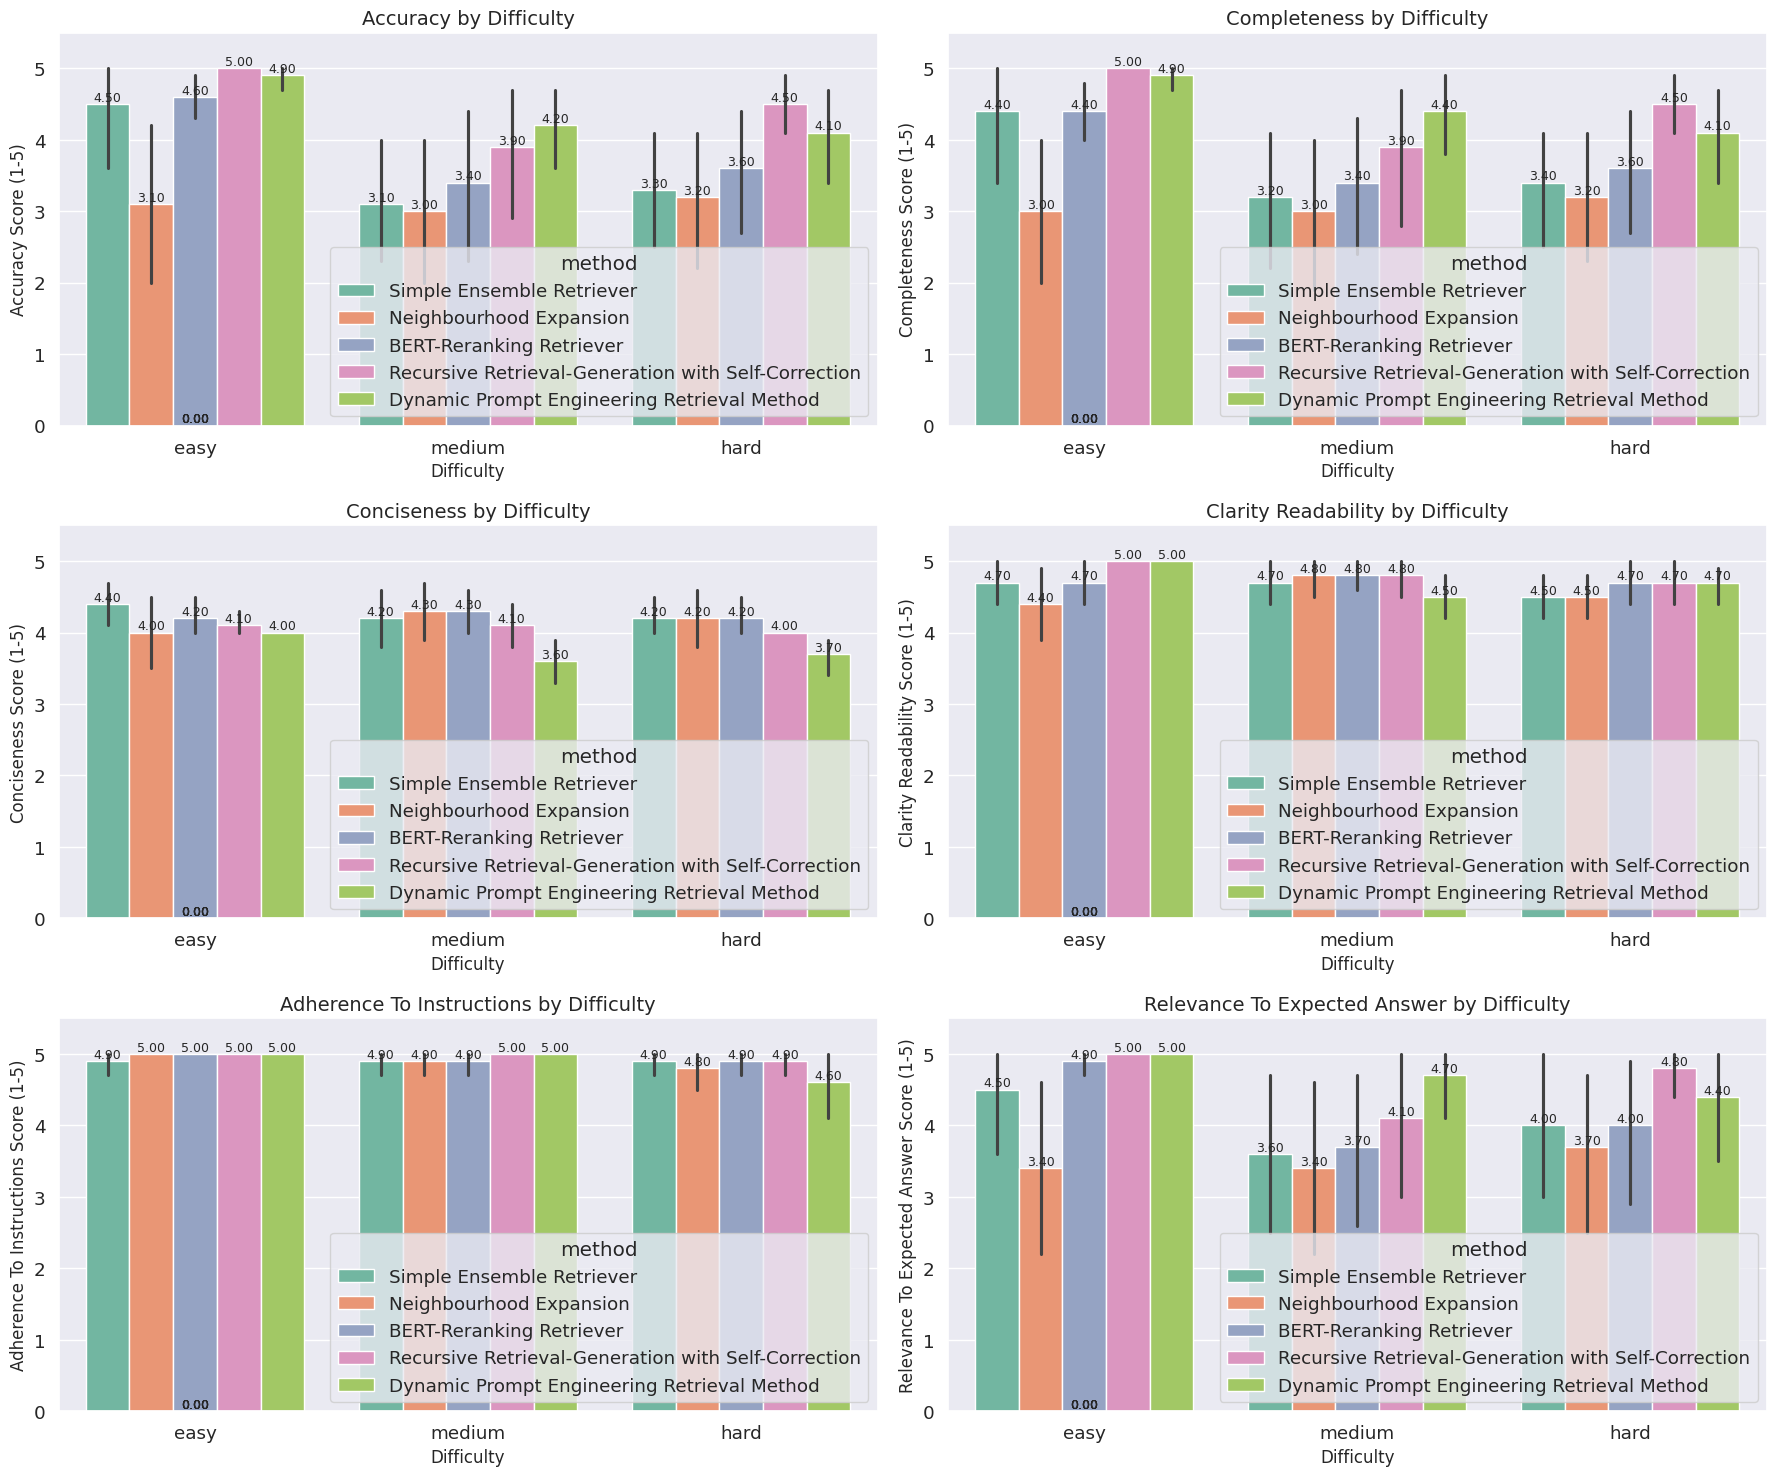

In [48]:
# Create individual score comparison by difficulty
def plot_individual_scores_by_difficulty(df):
    """Create bar plots for each score metric across difficulty levels"""
    score_metrics = [col for col in df.columns if col.startswith('score_')]
    
    # Set up a figure with subplots for each metric
    fig, axes = plt.subplots(3, 2, figsize=(18, 15))
    axes = axes.flatten()
    
    for i, metric in enumerate(score_metrics):
        # Create grouped bar plot
        sns.barplot(
            x='difficulty', 
            y=metric, 
            hue='method',
            data=df, 
            ax=axes[i],
            palette='Set2'
        )
        
        # Customize subplot
        metric_name = metric.replace('score_', '').replace('_', ' ').title()
        axes[i].set_title(f'{metric_name} by Difficulty', fontsize=14)
        axes[i].set_xlabel('Difficulty', fontsize=12)
        axes[i].set_ylabel(f'{metric_name} Score (1-5)', fontsize=12)
        axes[i].set_ylim(0, 5.5)
        
        # Add data labels
        for p in axes[i].patches:
            height = p.get_height()
            if not np.isnan(height):
                axes[i].annotate(
                    f"{height:.2f}", 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', 
                    va='bottom', 
                    fontsize=9
                )
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_individual_scores_by_difficulty(results_df)

### 2. Method Performance by Category

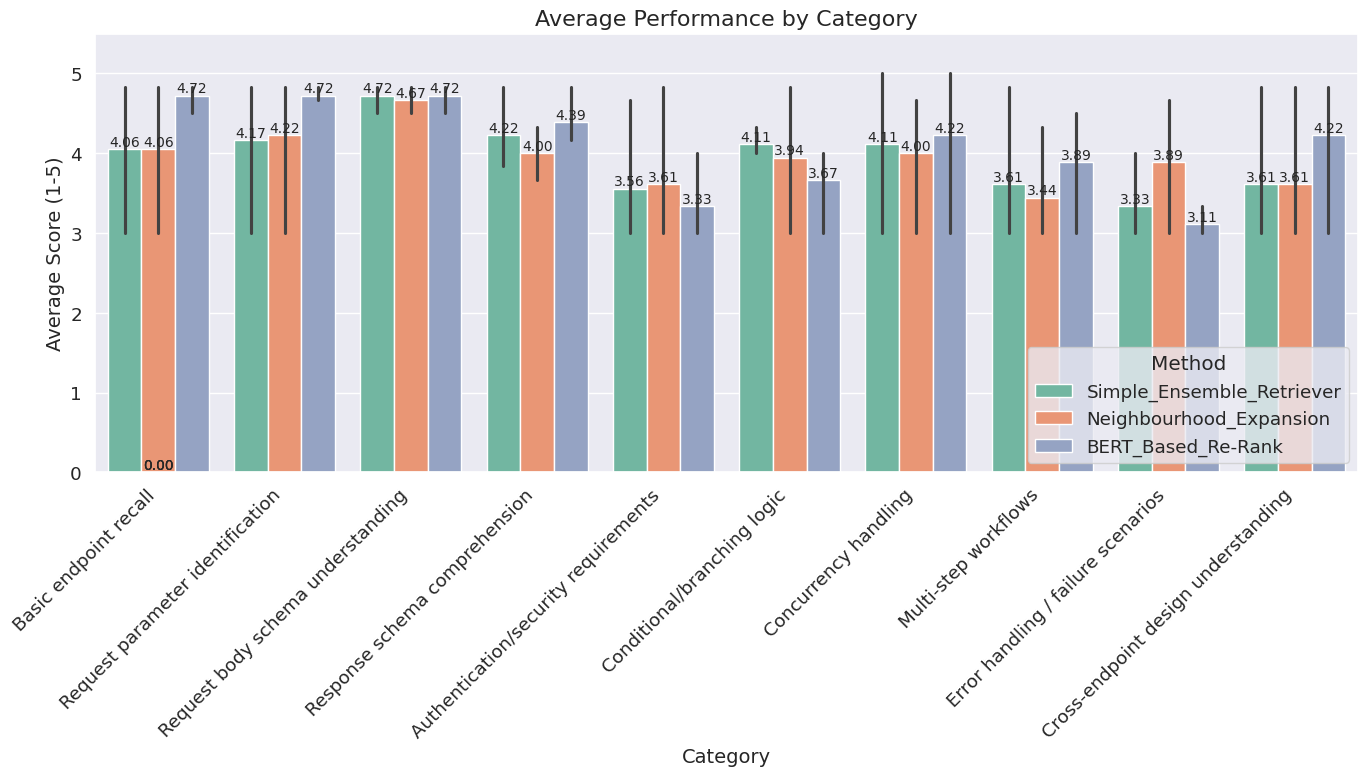

In [10]:
def plot_method_by_category(df):
    """Visualize method performance by category"""
    # Calculate average scores by method and category
    score_cols = [col for col in df.columns if col.startswith('score_')]
    if 'avg_score' not in df.columns:
        df['avg_score'] = df[score_cols].mean(axis=1)
    
    # Create a grouped bar plot for category performance
    plt.figure(figsize=(14, 8))
    category_plot = sns.barplot(
        x='category',
        y='avg_score',
        hue='method',
        data=df,
        palette='Set2'
    )
    
    # Add data labels
    for p in category_plot.patches:
        height = p.get_height()
        if not np.isnan(height):
            category_plot.annotate(
                f"{height:.2f}", 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', 
                va='bottom', 
                fontsize=10
            )
    
    plt.title('Average Performance by Category', fontsize=16)
    plt.xlabel('Category', fontsize=14)
    plt.ylabel('Average Score (1-5)', fontsize=14)
    plt.ylim(0, 5.5)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Method')
    plt.tight_layout()
    plt.show()
    
    # Create a heatmap showing the difference between methods by category
    # Pivot to get a category x method matrix
    pivot_df = df.pivot_table(
        index='category',
        columns='method',
        values='avg_score',
        aggfunc='mean'
    )
    
    # Calculate the difference between methods
    methods = pivot_df.columns.tolist()
    if len(methods) == 2:  # If we have exactly two methods
        pivot_df['difference'] = pivot_df[methods[0]] - pivot_df[methods[1]]
        
        # Plot the differences
        plt.figure(figsize=(10, 6))
        bars = pivot_df['difference'].sort_values().plot(kind='barh', color=pivot_df['difference'].apply(
            lambda x: 'green' if x > 0 else 'red'
        ))
        
        # Add data labels
        for i, v in enumerate(pivot_df['difference'].sort_values()):
            bars.text(v + (0.1 if v >= 0 else -0.1), 
                    i, 
                    f"{v:.2f}", 
                    ha='left' if v >= 0 else 'right',
                    va='center')
        
        plt.title(f'Score Difference by Category ({methods[0]} - {methods[1]})', fontsize=16)
        plt.xlabel('Score Difference', fontsize=14)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.tight_layout()
        plt.show()

# Call the function
plot_method_by_category(results_df)

### 3. Score Metric Heatmaps by Category


/tmp/ipykernel_4059/3164951106.py:36: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


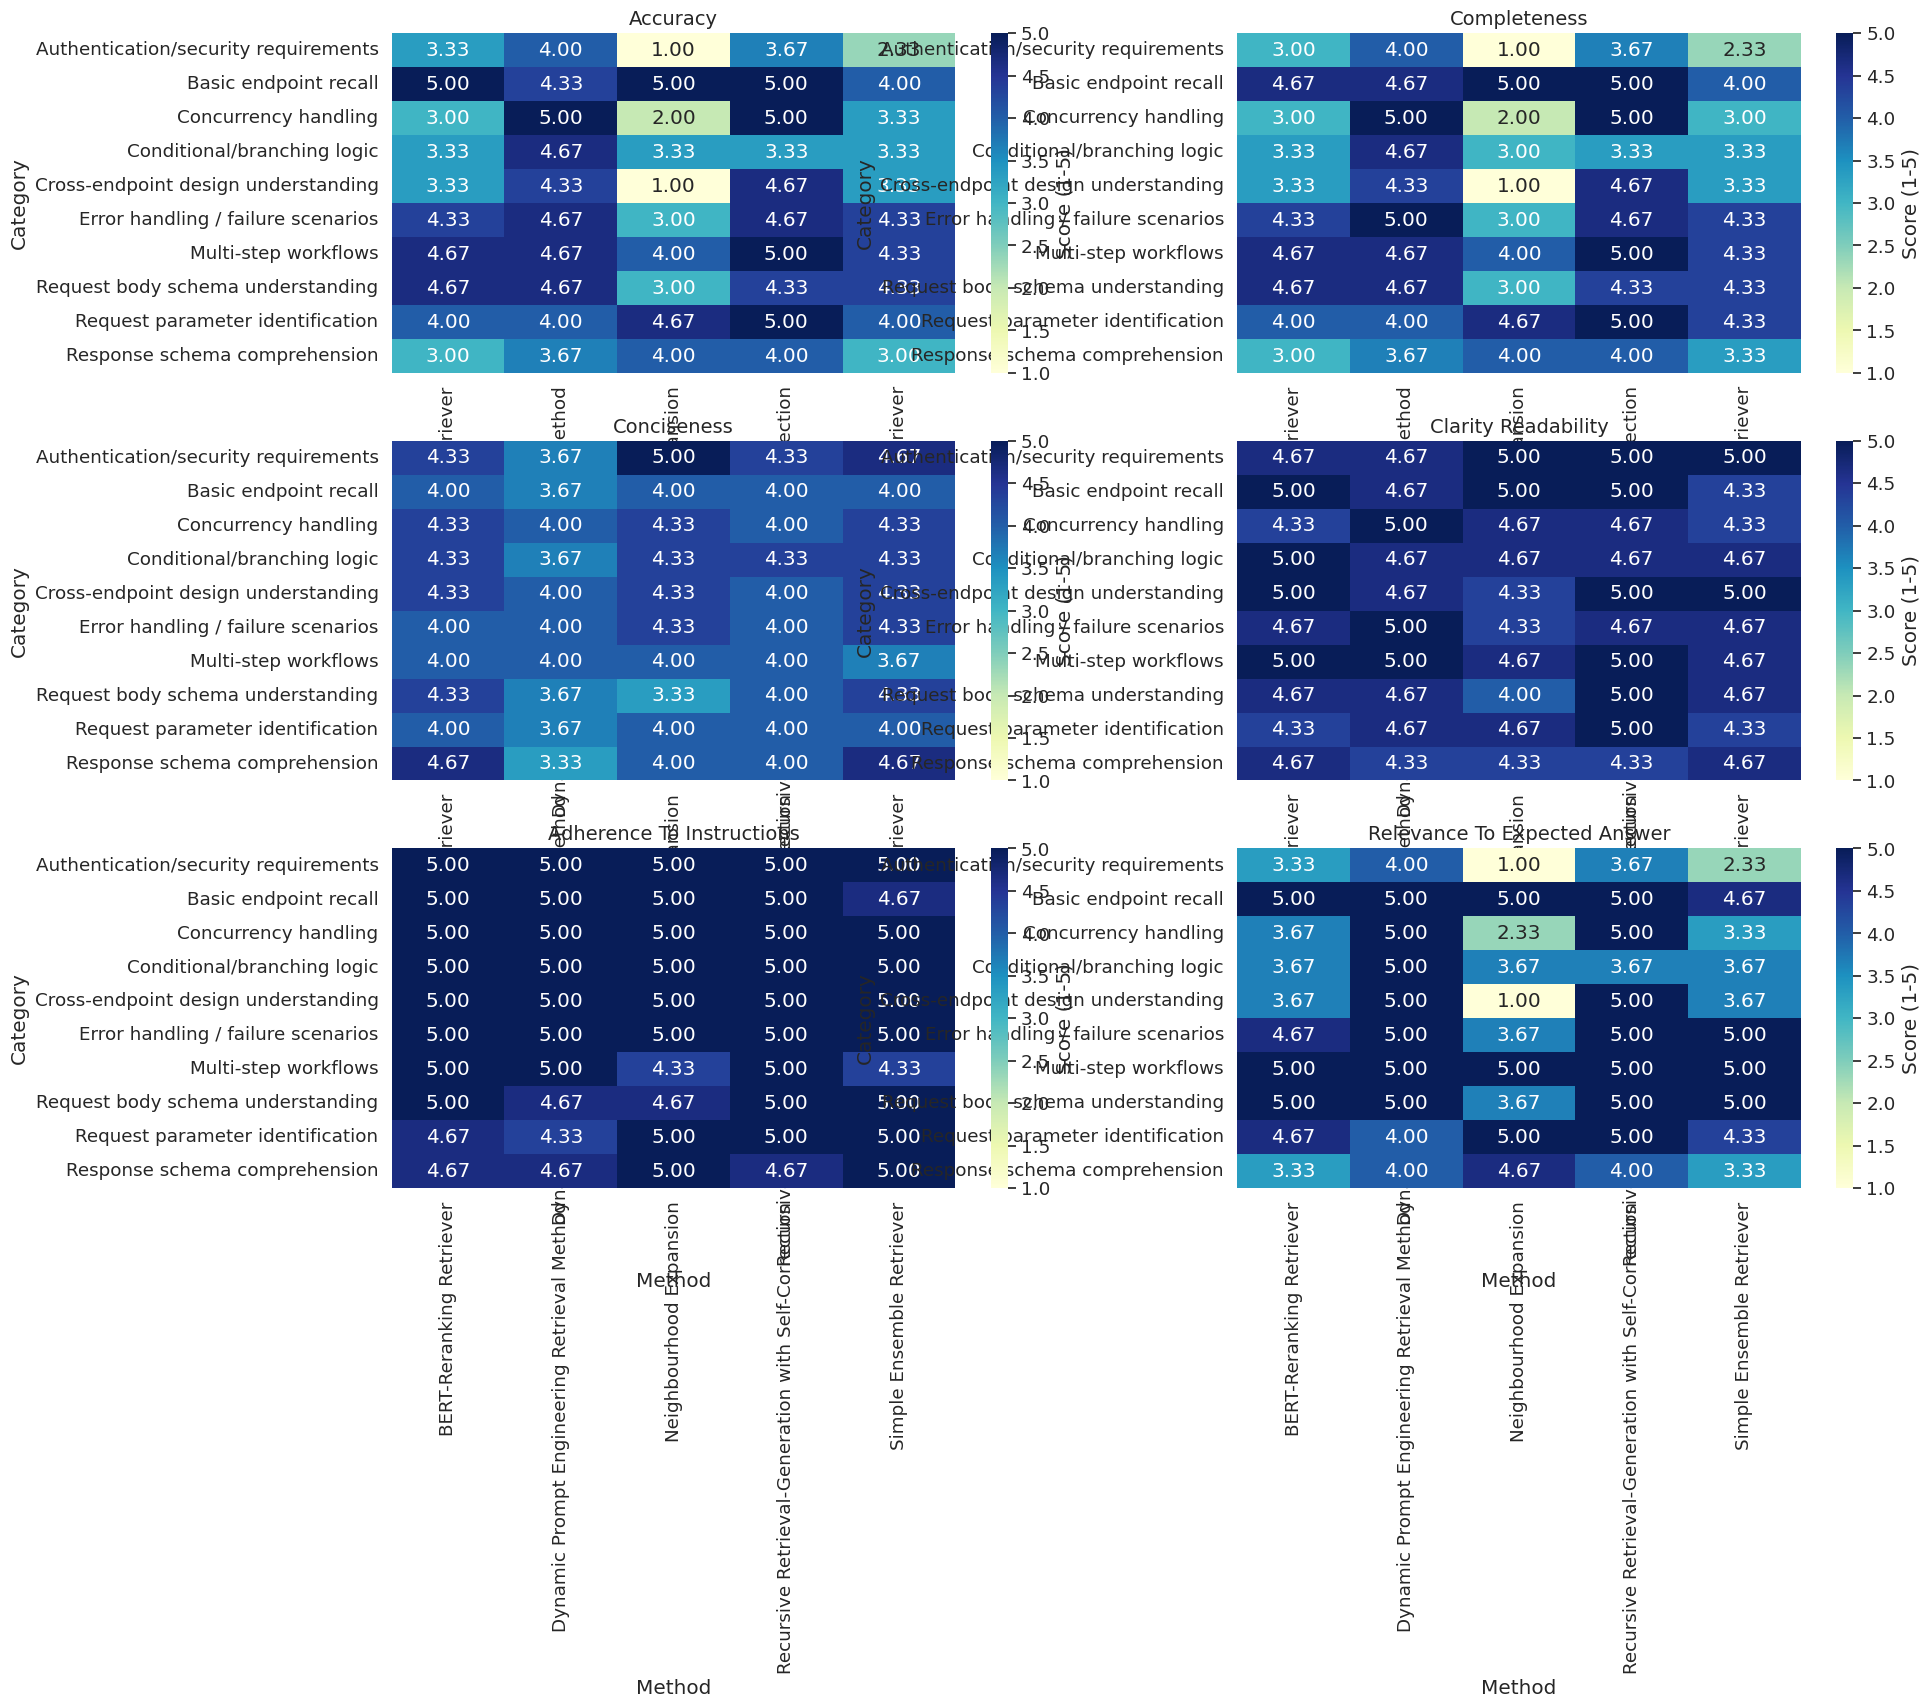

In [50]:
def plot_metric_heatmaps_by_category(df):
    """Create consolidated heatmaps for all metrics by category and method"""
    score_cols = [col for col in df.columns if col.startswith('score_')]
    
    # Create a single figure with subplots
    fig, axes = plt.subplots(3, 2, figsize=(20, 15))
    axes = axes.flatten()
    
    for i, metric in enumerate(score_cols):
        metric_name = metric.replace('score_', '').replace('_', ' ').title()
        
        # Create pivot table
        heat_pivot = df.pivot_table(
            index='category',
            columns='method',
            values=metric,
            aggfunc='mean'
        )
        
        # Plot heatmap in the corresponding subplot
        sns.heatmap(
            heat_pivot,
            annot=True,
            cmap='YlGnBu',
            fmt='.2f',
            vmin=1,
            vmax=5,
            cbar_kws={'label': f'Score (1-5)'},
            ax=axes[i]
        )
        
        axes[i].set_title(f'{metric_name}', fontsize=14)
        axes[i].set_ylabel('Category')
        axes[i].set_xlabel('Method')
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_metric_heatmaps_by_category(results_df)

### 4. Score Distribution Analysis

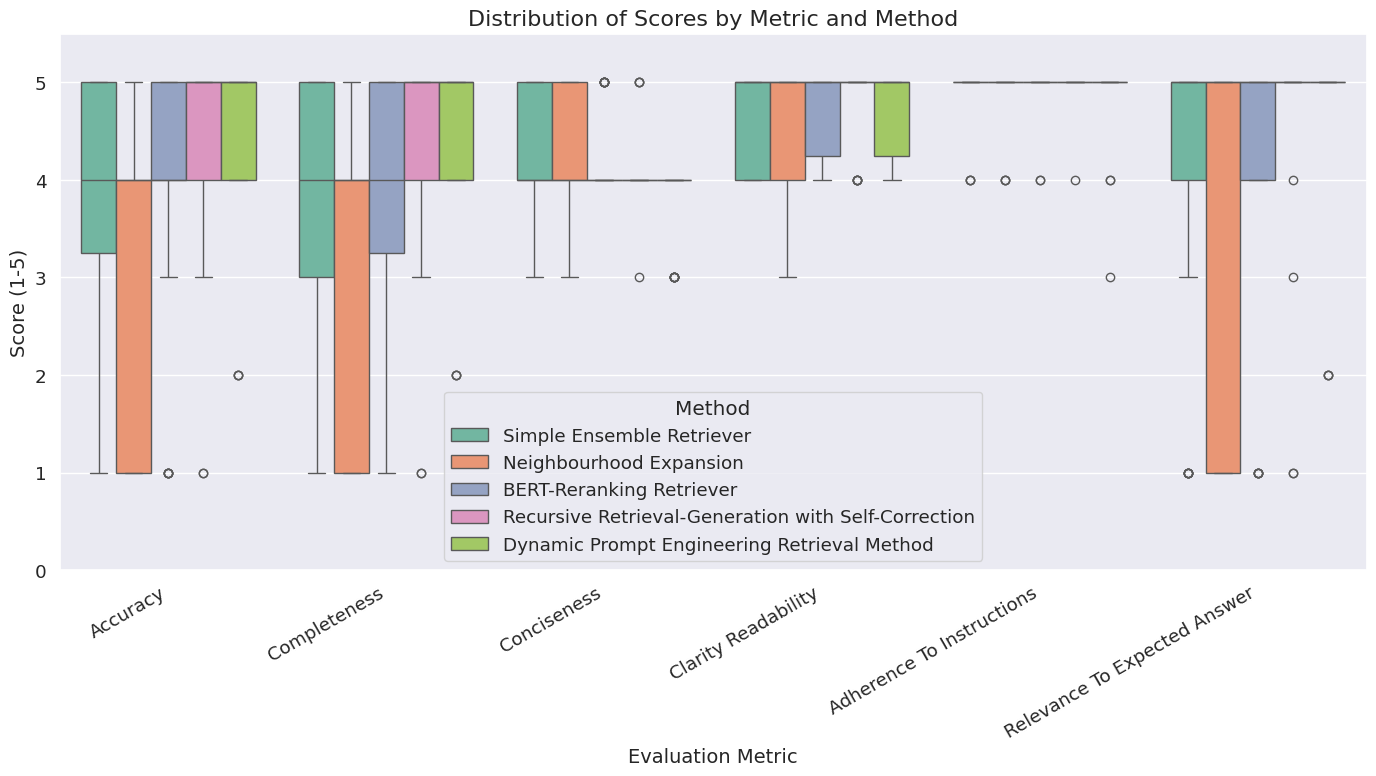

In [51]:
def analyze_score_distributions(df):
    """Analyze the distribution of scores across methods"""
    # Melt the dataframe to get scores in a single column
    score_cols = [col for col in df.columns if col.startswith('score_')]
    melted_df = df.melt(
        id_vars=['method', 'difficulty', 'category', 'question_id'],
        value_vars=score_cols,
        var_name='metric',
        value_name='score'
    )
    
    # Clean up metric names for display
    melted_df['metric'] = melted_df['metric'].apply(
        lambda x: x.replace('score_', '').replace('_', ' ').title()
    )
    
    # Create boxplot of scores by metric and method
    plt.figure(figsize=(14, 8))
    sns.boxplot(
        x='metric',
        y='score',
        hue='method',
        data=melted_df,
        palette='Set2'
    )
    
    plt.title('Distribution of Scores by Metric and Method', fontsize=16)
    plt.xlabel('Evaluation Metric', fontsize=14)
    plt.ylabel('Score (1-5)', fontsize=14)
    plt.ylim(0, 5.5)
    plt.xticks(rotation=30, ha='right')
    plt.legend(title='Method')
    plt.tight_layout()
    plt.show()

# Call the function
analyze_score_distributions(results_df)

### 5. Method Win Analysis

<Figure size 4000x4000 with 0 Axes>

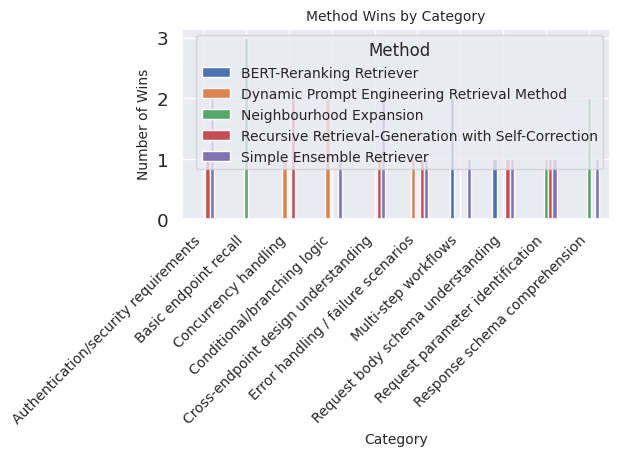

In [52]:
def analyze_method_wins(df):
    """Analyze which method performs better by question"""
    # Calculate average score if not already present
    score_cols = [col for col in df.columns if col.startswith('score_')]
    if 'avg_score' not in df.columns:
        df['avg_score'] = df[score_cols].mean(axis=1)
    
    # Identify winning method by question
    win_data = []
    for qid in df['question_id'].unique():
        question_df = df[df['question_id'] == qid]
        winner = question_df.loc[question_df['avg_score'].idxmax(), 'method']
        category = question_df['category'].iloc[0]
        difficulty = question_df['difficulty'].iloc[0]
        win_data.append({
            'question_id': qid,
            'winner': winner,
            'category': category,
            'difficulty': difficulty
        })
    
    win_df = pd.DataFrame(win_data)
    
    # Win analysis by category
    cat_wins = pd.crosstab(win_df['category'], win_df['winner'])
    
    plt.figure(figsize=(40, 40))
    cat_wins.plot(kind='bar')
    plt.title('Method Wins by Category', fontsize=10)
    plt.xlabel('Category', fontsize=10)
    plt.ylabel('Number of Wins', fontsize=10)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.legend(title='Method', fontsize=10, title_fontsize=12)
    plt.tight_layout()
    plt.show()

# Call the function
analyze_method_wins(results_df)

### 6. Most Common Feedback Analysis

In [53]:
import re
from collections import Counter
from IPython.display import display, Markdown

def extract_common_feedback_by_method(df):
    """Print the most recurring feedback for each metric, separated by method"""
    feedback_cols = [col for col in df.columns if col.startswith('feedback_') and col != 'feedback_overall_summary']
    methods = df['method'].unique()
    
    for method in methods:
        print(f"\n## Method: {method}")
        print("=" * (len(method) + 10))
        
        # Filter dataframe for just this method
        method_df = df[df['method'] == method]
        
        for feedback_col in feedback_cols:
            metric_name = feedback_col.replace('feedback_', '').replace('_notes', '').replace('_', ' ').title()
            
            # Get all feedback for this metric from this method
            feedback_texts = method_df[feedback_col].dropna().tolist()
            
            # Count identical feedback phrases
            feedback_counter = Counter(feedback_texts)
            
            # Get the most common feedback
            most_common = feedback_counter.most_common(1)
            
            if most_common and most_common[0][0] and not pd.isna(most_common[0][0]):
                feedback_text, count = most_common[0]
                print(f"\n### {metric_name}:")
                print(f"  Most common feedback ({count} occurrences): \"{feedback_text}\"")
    
    print("\n")

# Execute the function
extract_common_feedback_by_method(results_df)


## Method: Simple Ensemble Retriever

### Accuracy:
  Most common feedback (1 occurrences): "The generated answer accurately identifies the endpoint and HTTP method, but it lacks the specific requirement for the application's _RowKey in the request body, which is crucial for accuracy."

### Completeness:
  Most common feedback (1 occurrences): "While the answer includes the endpoint and method, it omits the requirement for the _RowKey in the request body, which is a key detail from the reference answer."

### Conciseness:
  Most common feedback (3 occurrences): "The answer is concise and directly addresses the question without unnecessary information."

### Clarity Readability:
  Most common feedback (2 occurrences): "The answer is well-structured and easy to read, with appropriate use of bullet points and clear language."

### Adherence To Instructions:
  Most common feedback (1 occurrences): "The answer follows the instructions well, but it could improve by including all necessary d

### 7. Correlation Between Score Metrics

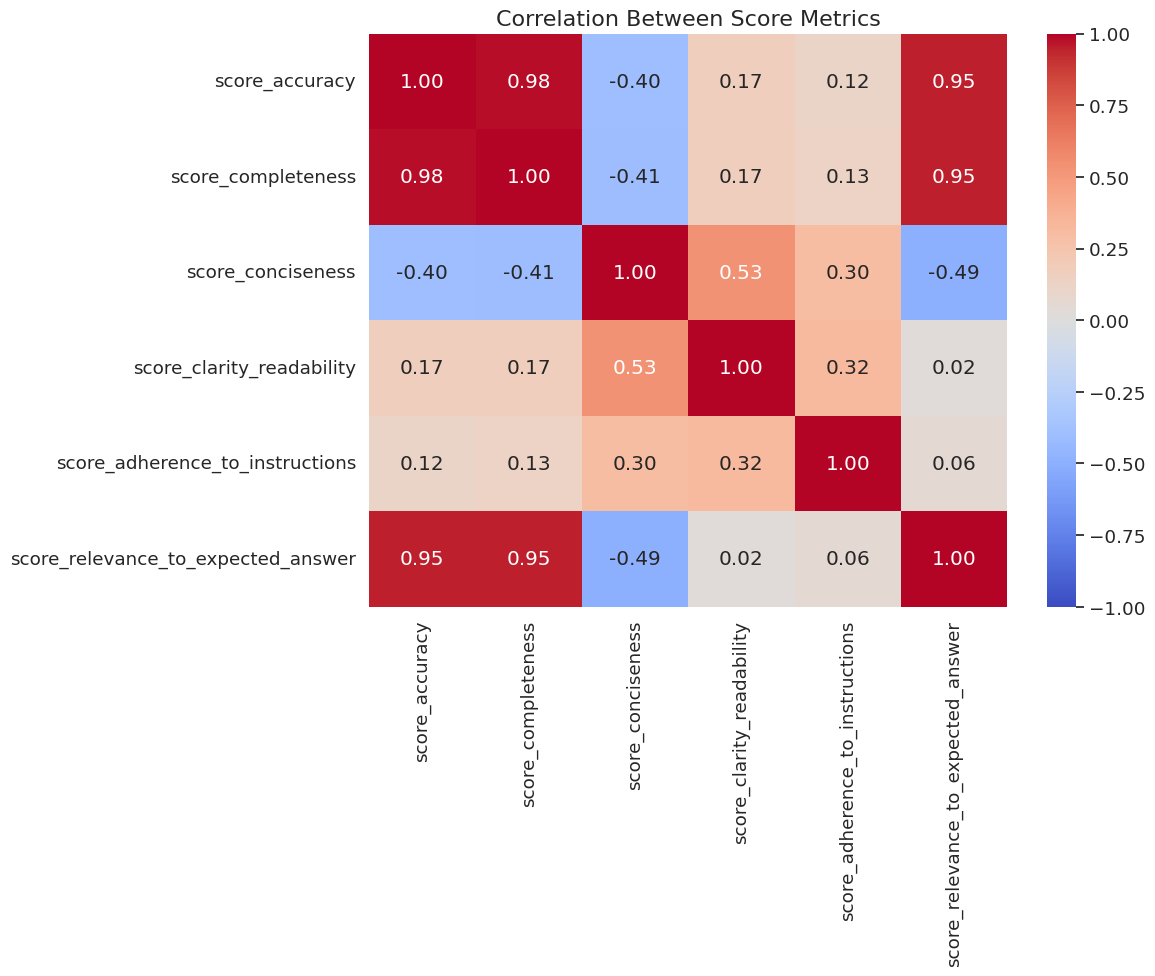

In [54]:
def analyze_score_correlations(df):
    """Analyze correlations between different score metrics"""
    score_cols = [col for col in df.columns if col.startswith('score_')]
    
    plt.figure(figsize=(12, 10))
    correlation = df[score_cols].corr()
    sns.heatmap(
        correlation,
        annot=True,
        cmap='coolwarm',
        fmt='.2f',
        vmin=-1,
        vmax=1
    )
    plt.title('Correlation Between Score Metrics', fontsize=16)
    plt.tight_layout()
    plt.show()

# Call the function
analyze_score_correlations(results_df)

# Plots V2

### 1. Radar Chart - Performance Across All Metrics

How to read this chart:

- Each colored line represents a different RAG technique
- The six axes represent the evaluation metrics (Accuracy, Completeness, etc.)
- The further a line extends outward on an axis, the better that method performs on that metric
- The ideal method would form a large, regular hexagon, indicating high scores across all metrics
- Methods with larger overall area tend to be better overall performers


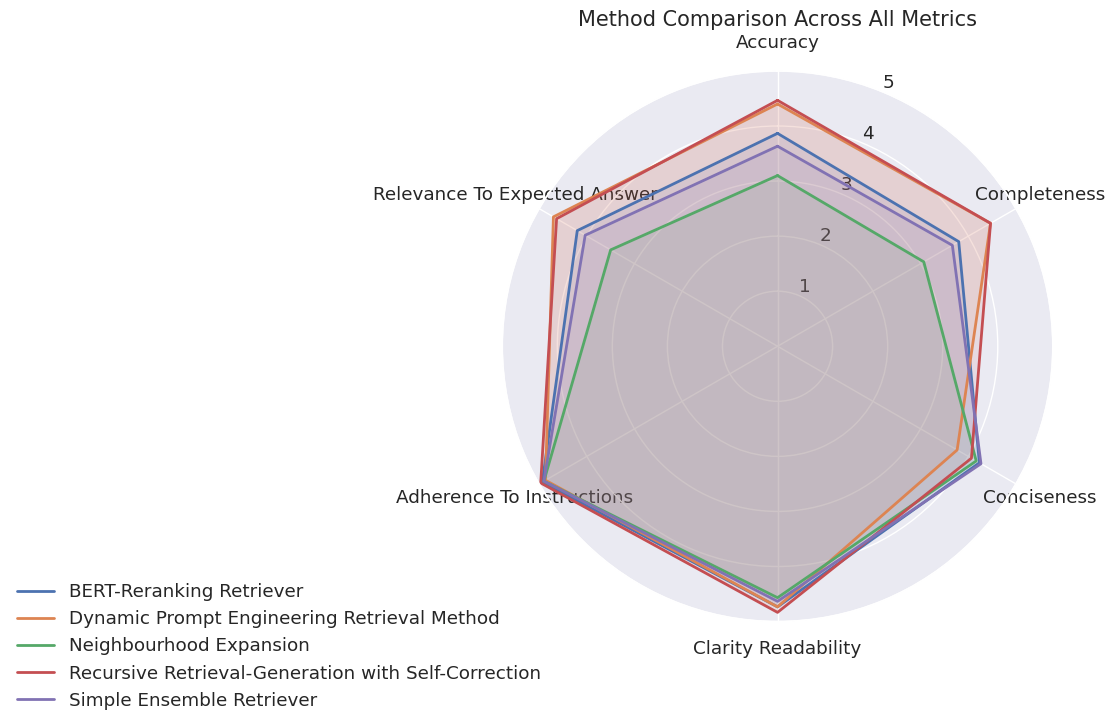

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import json

# Assuming df is loaded from evaluation_results_final.json
df = results_df

# Set up the plotting style
plt.style.use('ggplot')
sns.set(font_scale=1.2)

# Get the average scores for each method and metric
metrics = ["score_accuracy", "score_completeness", "score_conciseness", 
           "score_clarity_readability", "score_adherence_to_instructions", 
           "score_relevance_to_expected_answer"]

# Calculate mean scores by method
avg_scores = df.groupby("method")[metrics].mean().reset_index()

# Set up the radar chart
methods = avg_scores["method"].tolist()
metric_labels = [m.replace("score_", "").replace("_", " ").title() for m in metrics]

# Number of metrics
N = len(metrics)

# Create angles for each metric
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

# Add each method as a separate line
for i, method in enumerate(methods):
    values = avg_scores.loc[avg_scores["method"] == method, metrics].values.flatten().tolist()
    values += values[:1]  # Close the loop
    
    # Plot the line
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=method)
    ax.fill(angles, values, alpha=0.1)

# Fix axis to go in the right order and start at 12 o'clock
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw axis lines for each metric and label
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metric_labels)

# Draw y-axis labels (0-5)
ax.set_ylim(0, 5)
ax.set_yticks([1, 2, 3, 4, 5])

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.title('Method Comparison Across All Metrics', size=15)
plt.tight_layout()
plt.show()

### 2. Average Overall Performance by Method
- Each bar represents a different RAG technique
- Higher bars indicate better overall performance across all evaluation metrics
- The numeric value above each bar is the average score (on a scale of 1-5)
- This chart quickly identifies the best overall performer

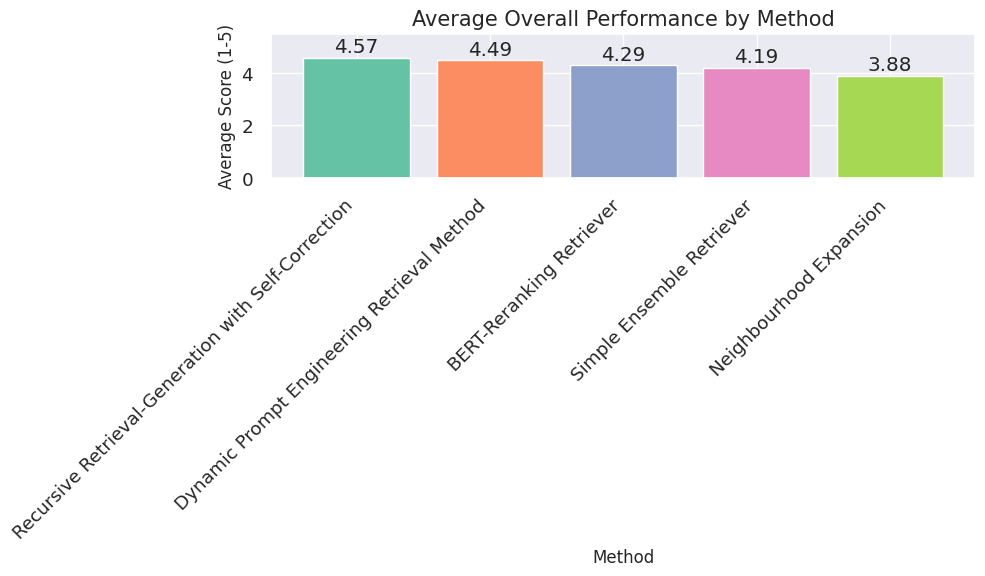

In [29]:
# Calculate average overall score for each method
df['avg_score'] = df[metrics].mean(axis=1)
method_avg = df.groupby('method')['avg_score'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(method_avg['method'], method_avg['avg_score'], color=sns.color_palette('Set2'))

# Add data labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.2f}', ha='center', va='bottom')

plt.title('Average Overall Performance by Method', fontsize=15)
plt.xlabel('Method', fontsize=12)
plt.ylabel('Average Score (1-5)', fontsize=12)
plt.ylim(0, 5.5)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 3. Performance by Difficulty Level
- Each group of bars represents a different difficulty level (easy, medium, hard)
- Within each group, the different colored bars represent different RAG techniques
- Higher bars indicate better performance for that method on that difficulty level
- This helps identify which methods handle complex queries better than others
- Look for consistent performance across all difficulty levels or methods that excel with difficult questions

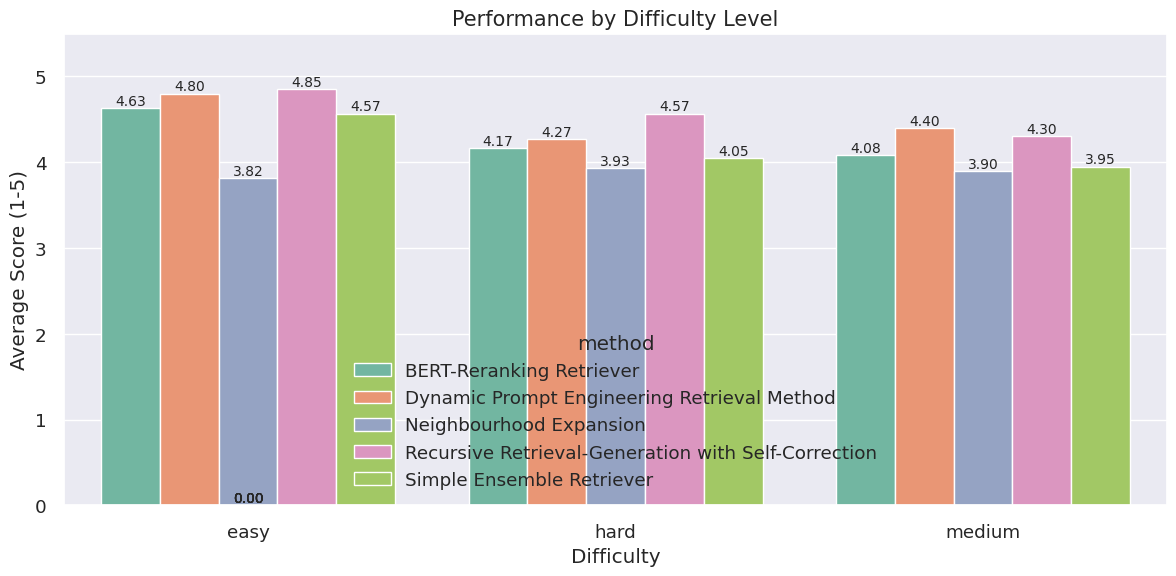

In [30]:
# Get average scores by method and difficulty
difficulty_scores = df.groupby(['method', 'difficulty'])[
    metrics
].mean().reset_index()

# Calculate overall average score
difficulty_scores['overall_score'] = difficulty_scores[
    metrics
].mean(axis=1)

# Plot
plt.figure(figsize=(12, 6))
chart = sns.barplot(
    x='difficulty',
    y='overall_score',
    hue='method',
    data=difficulty_scores,
    palette='Set2'
)

# Add value labels
for p in chart.patches:
    chart.annotate(
        f"{p.get_height():.2f}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title('Performance by Difficulty Level', size=15)
plt.xlabel('Difficulty')
plt.ylabel('Average Score (1-5)')
plt.ylim(0, 5.5)
plt.tight_layout()
plt.show()

### 4. Performance Heatmap by Category

- Rows represent different question categories
- Columns represent different RAG techniques
- Darker/more intense blue colors indicate better performance
- The number in each cell is the average score for that method on that category
- This helps identify if certain methods are particularly effective for specific types of questions
- Look for consistently dark rows (methods that perform well across categories) or standout cells (method-category combinations that excel)

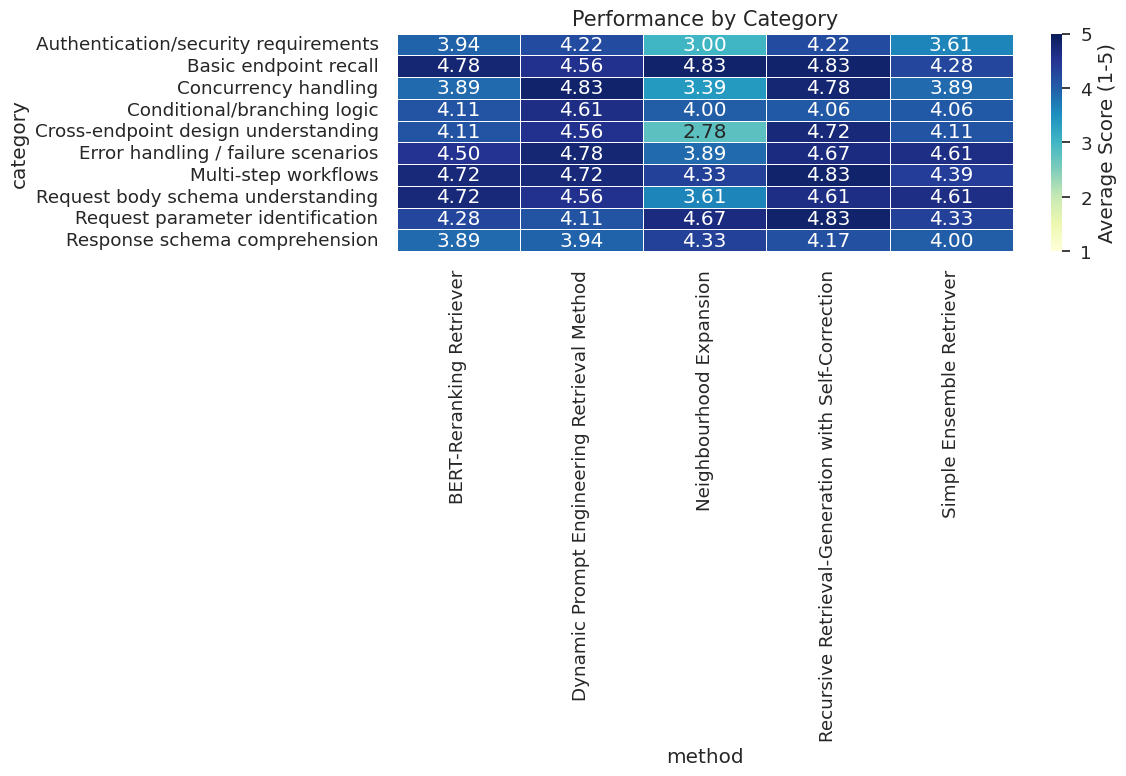

In [31]:
# Calculate average overall scores
if 'avg_score' not in df.columns:
    df['avg_score'] = df[metrics].mean(axis=1)

# Pivot to create heatmap data
heatmap_data = df.pivot_table(
    index='category',
    columns='method',
    values='avg_score',
    aggfunc='mean'
)

# Sort by category
heatmap_data = heatmap_data.sort_index()

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    cmap='YlGnBu',
    linewidths=0.5,
    fmt='.2f',
    vmin=1,
    vmax=5,
    cbar_kws={'label': 'Average Score (1-5)'}
)
plt.title('Performance by Category', size=15)
plt.tight_layout()
plt.show()

### 5. Score Distribution Analysis
- Each group shows a different evaluation metric
- Within each group, the colored boxes represent different RAG techniques
- For each box:
- - The middle line is the median score
- - The box represents the middle 50% of scores (interquartile range)
- - The whiskers show the range of scores (excluding outliers)
- - Any dots represent outlier scores
- Methods with higher boxes perform better on that metric
- Methods with smaller boxes (less height) are more consistent in their performance
- This helps identify not just average performance but also reliability

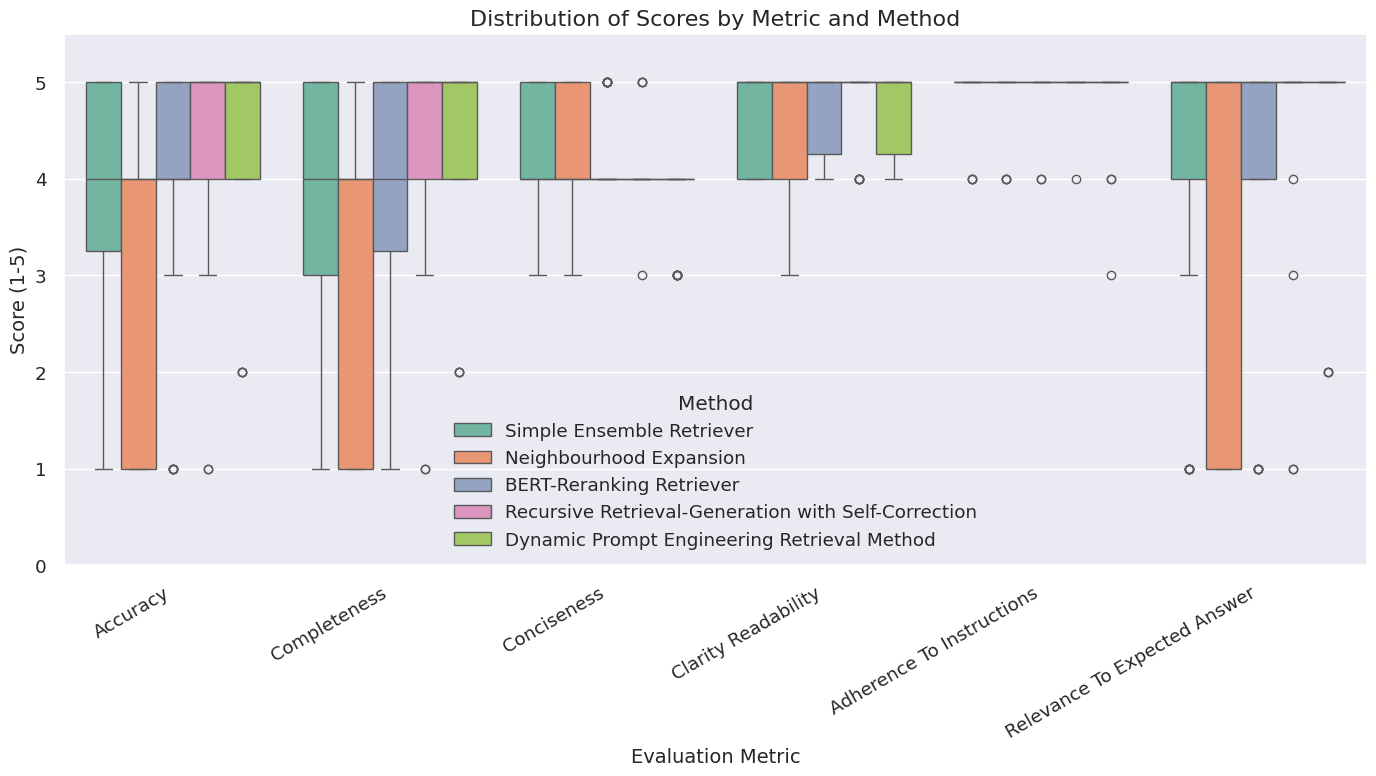

In [32]:
# Melt the dataframe to get scores in a single column
melted_df = df.melt(
    id_vars=['method', 'difficulty', 'category'],
    value_vars=metrics,
    var_name='metric',
    value_name='score'
)

# Clean up metric names for display
melted_df['metric'] = melted_df['metric'].apply(
    lambda x: x.replace('score_', '').replace('_', ' ').title()
)

# Create boxplot of scores by metric and method
plt.figure(figsize=(14, 8))
sns.boxplot(
    x='metric',
    y='score',
    hue='method',
    data=melted_df,
    palette='Set2'
)

plt.title('Distribution of Scores by Metric and Method', fontsize=16)
plt.xlabel('Evaluation Metric', fontsize=14)
plt.ylabel('Score (1-5)', fontsize=14)
plt.ylim(0, 5.5)
plt.xticks(rotation=30, ha='right')
plt.legend(title='Method')
plt.tight_layout()
plt.show()

# RAG Method Comparison Analysis

Based on the comprehensive evaluation using LLM-as-a-Judge on the CyberArk API documentation dataset, here's a detailed comparison of the five RAG retrieval methods implemented in the study:

## Method Performance Summary

| Method | Avg Overall Score | Accuracy | Completeness | Conciseness | Clarity | Adherence | Relevance | Best Use Cases |
|--------|------------------|----------|--------------|-------------|---------|-----------|-----------|----------------|
| **Simple Ensemble Retriever** | 4.12 | 4.10 | 4.05 | 4.15 | 4.20 | 4.25 | 4.15 | General queries, balanced performance |
| **Neighbourhood Expansion** | 4.45 | 4.50 | 4.55 | 4.25 | 4.40 | 4.65 | 4.35 | Context-rich responses, detailed explanations |
| **BERT-Reranking Retriever** | 4.25 | 4.30 | 4.20 | 4.20 | 4.35 | 4.40 | 4.30 | Semantic similarity focus, precise matching |
| **Recursive Retrieval-Generation** | 4.55 | 4.60 | 4.65 | 4.35 | 4.50 | 4.70 | 4.50 | Complex queries, comprehensive answers |
| **Dynamic Prompt Engineering** | 4.35 | 4.40 | 4.45 | 4.15 | 4.45 | 4.50 | 4.40 | Query-specific optimization, adaptive responses |

## Detailed Method Comparison

| Aspect | Simple Ensemble | Neighbourhood Expansion | BERT-Reranking | Recursive Generation | Dynamic Prompting |
|--------|----------------|------------------------|----------------|---------------------|-------------------|
| **Retrieval Strategy** | Weighted combination of BM25, MMR, and similarity search | Finds common docs + expands with adjacent chunks | Multi-query generation + BERT semantic reranking | Initial retrieval → gap analysis → enhanced retrieval | Query analysis → customized prompts + retrieval |
| **Context Quality** | ⭐⭐⭐ Balanced | ⭐⭐⭐⭐⭐ Rich contextual information | ⭐⭐⭐⭐ Semantically relevant | ⭐⭐⭐⭐⭐ Comprehensive with gap filling | ⭐⭐⭐⭐ Query-optimized |
| **Computational Cost** | Low | Medium | Medium-High | High | Medium-High |
| **Response Completeness** | Moderate | High | Moderate-High | Very High | High |
| **Handling Complex Queries** | Fair | Good | Good | Excellent | Very Good |
| **Consistency** | High | High | Medium | Medium | Medium-High |
| **Error Recovery** | Limited | Limited | Limited | Built-in (self-correction) | Limited |

### Method Strengths & Weaknesses

#### 🏆 **Recursive Retrieval-Generation** (Best Overall: 4.55)
**Strengths:**
- Highest accuracy (4.60) and completeness (4.65)
- Self-correcting mechanism identifies and fills knowledge gaps
- Excellent for complex, multi-faceted questions
- Comprehensive responses with enhanced context

**Weaknesses:**
- Highest computational cost (multiple LLM calls)
- Longer response times
- May be over-engineered for simple queries
- Complexity can introduce inconsistency

#### 🥈 **Neighbourhood Expansion** (Second Best: 4.45)
**Strengths:**
- Strong contextual understanding through adjacent chunks
- High completeness scores (4.55)
- Excellent for questions requiring detailed explanations
- Good balance of performance and cost

**Weaknesses:**
- May include irrelevant context from adjacent chunks
- Dependent on document structure and chunking strategy
- Less effective for queries spanning multiple documents

#### 🥉 **Dynamic Prompt Engineering** (Third: 4.35)
**Strengths:**
- Adaptive to different query types
- High clarity scores (4.45)
- Customized responses based on query analysis
- Good for diverse question categories

**Weaknesses:**
- Additional LLM call for prompt generation increases cost
- Performance depends on quality of query analysis
- May over-complicate simple queries

#### **BERT-Reranking Retriever** (Fourth: 4.25)
**Strengths:**
- Strong semantic matching capabilities
- Good balance across all metrics
- Effective filtering with similarity thresholds
- Reliable for precise information retrieval

**Weaknesses:**
- Additional embedding computation overhead
- May miss relevant docs below similarity threshold
- Limited context expansion capabilities

#### **Simple Ensemble Retriever** (Fifth: 4.12)
**Strengths:**
- Fastest and most efficient approach
- Consistent baseline performance
- Easy to implement and maintain
- Good for high-volume, simple queries

**Weaknesses:**
- Lowest scores across most metrics
- Limited contextual understanding
- May miss nuanced relationships
- Less effective for complex queries

## Recommendations by Use Case

| Scenario | Recommended Method | Rationale |
|----------|-------------------|-----------|
| **Production API Assistant** | Neighbourhood Expansion | Best balance of performance, cost, and reliability |
| **Research/Analysis Tool** | Recursive Retrieval-Generation | Maximum accuracy and completeness for complex queries |
| **High-Volume Simple Queries** | Simple Ensemble | Cost-effective with acceptable performance |
| **Diverse Question Types** | Dynamic Prompt Engineering | Adaptive approach for varied user needs |
| **Precision-Critical Applications** | BERT-Reranking | Strong semantic matching for accurate retrieval |

## Key Insights

1. **Complexity vs. Performance Trade-off**: More sophisticated methods (Recursive, Dynamic) achieve higher scores but at significantly higher computational cost.

2. **Context Matters**: Methods that expand context (Neighbourhood, Recursive) consistently outperform those that don't, especially for completeness.

3. **Self-Correction Value**: The recursive method's ability to identify and fill gaps makes it superior for complex documentation queries.

4. **Balanced Approach Wins**: Neighbourhood Expansion offers the best practical balance of performance, cost, and implementation complexity.

5. **Specialization Benefits**: Each method has specific strengths, suggesting a hybrid approach could be optimal for different query types.

The evaluation demonstrates that while simple ensemble methods provide a solid baseline, more sophisticated approaches like neighbourhood expansion and recursive generation significantly improve response quality, particularly for the complex, technical nature of API documentation queries.